# Fixed SAC for Epileptic Model

All critical bugs have been fixed. Run cells in order.


In [178]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

import collections
import random
import time
from tqdm import tqdm


In [179]:
DEVICE = torch.device("cpu")
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)


In [180]:
import numpy as np


class EpilepticNeuralMassJR:
    """
    Jansen–Rit-style neural mass model with an explicit DBS input.

    Populations:
        - P: pyramidal cells
        - E: excitatory interneurons
        - I: inhibitory interneurons

    State vector y = [y1, y2, y3, y4, y5, y6]
        y1: P average membrane potential
        y2: E average membrane potential
        y3: I average membrane potential
        y4: d/dt y1
        y5: d/dt y2
        y6: d/dt y3

    Dynamics:
        Second-order PSP operators for each population, driven by sigmoidal
        firing from the others and external input p(t) + DBS(t).

    DBS coupling:
        - DBS current enters as an additive term to the pyramidal input
          (you can change this if you prefer to target E or I).

    All parameters are exposed so you can push the model into
    more “epileptogenic” regimes if needed.
    """

    def __init__(
        self,
        A=3.25,      # mV, excitatory gain
        B=22.0,      # mV, inhibitory gain
        a=100.0,     # s^-1, excitatory inverse time constant
        b=50.0,      # s^-1, inhibitory inverse time constant
        e0=2.5,      # max firing rate (s^-1)
        v0=6.0,      # sigmoidal threshold (mV)
        r=0.56,      # sigmoid slope (mV^-1)
        C=68.0,       # FIX: Reduced from 135.0 to stabilize
        p_mean=90.0,  # FIX: Reduced from 120.0
        p_std=5.0,    # FIX: Reduced from 30.0
        epileptogenic_boost=1.0,  # FIX: Start stable
        rng=None,
    ):
        # --- store base connectivity so we can re-apply boost later (plasticity) ---
        self._C_base = float(C)

        # Default endpoint values for disease mapping (tune if you want)
        self.p_mean_normal = 90.0
        self.p_mean_ictal  = 130.0
        self.boost_normal  = 1.0
        self.boost_ictal   = 1.3

        # initialise current parameters
        self.p_mean = float(p_mean)
        self.p_std  = float(p_std)

        # set connectivity using the initial boost
        self._set_connectivity(float(epileptogenic_boost))


        self.A = A
        self.B = B
        self.a = a
        self.b = b

        self.e0 = e0
        self.v0 = v0
        self.r = r

        self.p_mean = p_mean
        self.p_std = p_std

        self.rng = np.random.default_rng() if rng is None else rng

                # --- Slow disease / excitability state --------------------------------
        # disease_level in [0,1]: 0 = normal, 1 = strongly epileptic
        self.disease_level = 0.0

        # how fast the system tends to get worse (per RL step) if untreated
        self.disease_drift = 0.01     # tune: 0.005–0.02

        # how strongly seizure suppression pushes back toward normal
        self.disease_control_gain = 0.1  # tune: 0.05–0.2

        # JR parameter values for the two extremes.
        # Replace "p_drive" with whatever your JR uses (e.g. p, I_ext, etc.).
        self.jr_params_normal = {"p_drive": 90.0}
        self.jr_params_ictal  = {"p_drive": 130.0}


    def _set_connectivity(self, boost: float) -> None:
        """Reset connectivity constants from base C and a boost factor (no accumulation)."""
        C = self._C_base
        boost = float(boost)

        self.C1 = C * boost
        self.C2 = 0.8 * C * boost
        self.C3 = 0.25 * C
        self.C4 = 0.25 * C

    def set_disease_level(self, d: float) -> None:
        """
        d in [0,1]. 0 = healthy, 1 = epileptogenic.
        Maps disease to background drive + excitatory connectivity boost.
        """
        d = float(np.clip(d, 0.0, 1.0))

        self.p_mean = (1.0 - d) * self.p_mean_normal + d * self.p_mean_ictal
        boost = (1.0 - d) * self.boost_normal + d * self.boost_ictal
        self._set_connectivity(boost)


    import numpy as np

    def _normalize_seizure_raw_safe(self, raw: float) -> float:
        # allow reset/calibration to run before baseline/scale are set
        if getattr(self, "seizure_baseline", None) is None or getattr(self, "seizure_scale", None) is None:
            return 0.0

        base = float(self.seizure_baseline)
        s = max(float(self.seizure_scale), 1e-3)

        z = (float(raw) - base) / s
        z = max(0.0, z)
        idx = z / (1.0 + z)
        return float(np.clip(idx, 0.0, 1.0))


    def S(self, v):
        """
        Sigmoidal firing-rate function.
        """
        return 2.0 * self.e0 / (1.0 + np.exp(self.r * (self.v0 - v)))

    def _deriv(self, y, t, dbs_val):
        """
        Compute time derivative dy/dt for state y at time t given DBS amplitude.
        """
        y1, y2, y3, y4, y5, y6 = y

        # External input p(t): noisy drive + can be modulated if needed
        p_t = self.p_mean + self.p_std * self.rng.standard_normal()

        # Firing rates
        S_p = self.S(y2 - y3)          # pyramidal output driven by E and I
        S_e = self.S(self.C1 * y1)     # excitatory input from pyramidal
        S_i = self.S(self.C3 * y1)     # inhibitory input from pyramidal

        # Add DBS as extra input to pyramidal (can interpret as current)
        # DBS is added to the excitatory input term here:
        # you can scale it or change how it couples.
        I_dbs = dbs_val

        # Differential equations (Jansen–Rit)
        dy1_dt = y4
        dy4_dt = self.A * self.a * (S_e + p_t + I_dbs) - 2.0 * self.a * y4 - (self.a ** 2) * y1

        dy2_dt = y5
        dy5_dt = self.A * self.a * (self.C2 * S_p) - 2.0 * self.a * y5 - (self.a ** 2) * y2

        dy3_dt = y6
        dy6_dt = self.B * self.b * (self.C4 * S_i) - 2.0 * self.b * y6 - (self.b ** 2) * y3

        return np.array([dy1_dt, dy2_dt, dy3_dt, dy4_dt, dy5_dt, dy6_dt])

        # ------------------------------------------------------------------
    # Map disease_level ∈ [0,1] into JR parameters
    # ------------------------------------------------------------------
    def _apply_jr_params_from_disease(self):
        """
        Map self.disease_level in [0,1] to a JR background drive between
        'normal' and 'ictal'.
        """
        p_norm = self.jr_regimes["normal"]["p_drive"]
        p_ict  = self.jr_regimes["ictal"]["p_drive"]

        # linear interpolation: 0 -> normal, 1 -> ictal
        p_current = (1.0 - self.disease_level) * p_norm + self.disease_level * p_ict

        # write this into the actual JR model parameter:
        self.jr.p_drive = p_current      # <<< or whatever param name you use



    def simulate(
        self,
        T=10.0,
        dt=0.0005,
        dbs_fun=None,
        y0=None,
        record_downsample=10,
    ):
        """
        Simulate the neural mass for duration T with step dt.

        Parameters
        ----------
        T : float
            Total duration in seconds.
        dt : float
            Integration timestep in seconds.
        dbs_fun : callable or None
            Function u = dbs_fun(t) giving DBS drive at time t (in arbitrary units).
            If None, DBS = 0 at all times.
        y0 : array-like or None
            Initial state. If None, start at zeros.
        record_downsample : int
            Store every Nth sample to reduce output size.

        Returns
        -------
        t_rec : (N_rec,) array
            Recorded time points.
        y_rec : (N_rec, 6) array
            State time series.
        v_out : (N_rec,) array
            “EEG-like” output: pyramidal potential y1.
        """
        n_steps = int(T / dt)
        if y0 is None:
            y = np.zeros(6, dtype=float)
        else:
            y = np.array(y0, dtype=float)

        if dbs_fun is None:
            def dbs_fun(t):
                return 0.0

        # Preallocate output lists
        t_list = []
        y_list = []
        v_list = []

        for k in range(n_steps):
            t = k * dt
            u = float(dbs_fun(t))

            # simple Euler–Maruyama integration
            dy = self._deriv(y, t, u)
            y = y + dt * dy

            if k % record_downsample == 0:
                t_list.append(t)
                y_list.append(y.copy())
                v_list.append(y[0])  # pyramidal potential

        t_rec = np.asarray(t_list)
        y_rec = np.vstack(y_list)
        v_out = np.asarray(v_list)

        return t_rec, y_rec, v_out


In [181]:
class EpilepsyDBSCombinedEnv(gym.Env):
    def __init__(
        self,
        jr_model=None,
        pac_model=None,
        step_T=0.1,
        dt=0.001,
        max_steps=100,
        amp_min=0.0,
        amp_max=5.0,
        freq_min=10.0,
        freq_max=200.0,
        pw_min=60.0,
        pw_max=450.0,
        amp_delta_max=0.25,
        freq_delta_max=5.0,
        pw_delta_max=10.0,
        w_seizure=3.0,
        w_energy=0.2,
        w_slew=0.005,
        w_disease=0.0,
        log_best_episodes=False,
        n_best_episodes=10,
        rng=None,
        default_regime="normal",
        seizure_metric="bandpower_ratio",
        seizure_band=(8.0, 30.0),
        total_band=(1.0, 80.0),
        seizure_norm="tanh",
        seizure_scale=0.15,
        seizure_target=0.2,
    ):
        super().__init__()

        self.prev_seizure_index = None
        self.w_delta_seizure = 0.5
        self.seiz_mu = 0.0
        self.seiz_var = 1.0
        self.seiz_n = 0
        self.seiz_eps = 1e-6
        self.seiz_sigmoid_k = 2.0
        self.seiz_update_stats = True

        self.use_burden_state = True
        self.burden_thr_normal = 0.20
        self.burden_thr_ictal = 0.50
        self.burden_drift_normal = 0.002
        self.burden_drift_preictal = 0.006
        self.burden_drift_ictal = 0.012
        self.burden_relief_gain = 0.020
        self.burden_noise_std = 0.010
        self.disease_up_rate = 0.010
        self.disease_down_rate = 0.002
        self.disease_floor = 0.0

        self.stim_k_amp = 1.0
        self.stim_k_freq = 1.0
        self.stim_k_pw = 1.0
        self.burden_relief_cap = 0.05

        self.w_seizure = float(w_seizure)
        self.w_energy = float(w_energy)
        self.w_slew = float(w_slew)
        self.w_disease = float(w_disease)

        self.seizure_metric = seizure_metric
        self.seizure_band = seizure_band
        self.total_band = total_band
        self.seizure_norm = seizure_norm
        self.seizure_scale = float(seizure_scale)
        self.seizure_target = float(seizure_target)

        self.dt = float(dt)
        self.step_T = float(step_T)
        self.fs = 1.0 / self.dt

        self.burden_phys_gain = 0.030
        self.burden_phys_tau = 10.0
        self._phys_ema = 0.0
        self.phys_raw_lo = 0.70
        self.phys_raw_hi = 1.10

        self.w_seiz = 1.0
        self.reward_scale = 1.0

        self.seizure_baseline = None
        self.baseline_margin = 0.02

        self.jr = jr_model if jr_model is not None else EpilepticNeuralMassJR()
        self.default_regime = default_regime
        self.disease_level = 0.0

        self.steps_per_step = int(self.step_T / self.dt)
        self.max_steps = int(max_steps)

        self.amp_min = float(amp_min)
        self.amp_max = float(amp_max)
        self.freq_min = float(freq_min)
        self.freq_max = float(freq_max)
        self.pw_min = float(pw_min)
        self.pw_max = float(pw_max)

        self.amp_delta_max = float(amp_delta_max)
        self.freq_delta_max = float(freq_delta_max)
        self.pw_delta_max = float(pw_delta_max)

        self.log_best_episodes = bool(log_best_episodes)
        self.n_best_episodes = int(n_best_episodes)
        self.best_episodes = []
        self.current_episode_log = None
        self.episode_reward = 0.0

        self.rng = np.random.default_rng() if rng is None else rng

        self.t = 0.0
        self.jr_state = None
        self.pac_state = None
        self.current_params = None
        self.prev_params = None
        self.step_count = 0

        self.disease_drift = 0.01
        self.disease_gain = 0.05
        self.disease_min = 0.0
        self.disease_max = 1.0

        self._seizure_scale = 0.25
        self._energy_ref = (self.amp_max ** 2) * self.freq_max * (self.pw_max / self.pw_max)

        self.jr_regimes = {
            "normal": {"p_drive": 80.0},
            "preictal": {"p_drive": 100.0},
            "ictal": {"p_drive": 130.0},
        }
        if default_regime not in self.jr_regimes:
            raise ValueError(f"Unknown default_regime '{default_regime}'")
        self.current_regime = default_regime

        self.observation_space = spaces.Box(
            low=np.zeros(5, dtype=np.float32),
            high=np.ones(5, dtype=np.float32),
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(3,),
            dtype=np.float32,
        )

    def _set_disease_from_regime(self, regime: str):
        if regime not in ("normal", "preictal", "ictal"):
            raise ValueError(f"Unknown regime '{regime}'")
        if regime == "normal":
            self.disease_level = 0.0
        elif regime == "preictal":
            self.disease_level = 0.5
        elif regime == "ictal":
            self.disease_level = 1.0
        self._apply_jr_params_from_disease()

    def _update_seizure_stats(self, x: float):
        self.seiz_n += 1
        if self.seiz_n == 1:
            self.seiz_mu = x
            self.seiz_var = 1.0
            return
        delta = x - self.seiz_mu
        self.seiz_mu += delta / self.seiz_n
        delta2 = x - self.seiz_mu
        self.seiz_var = ((self.seiz_n - 1) * self.seiz_var + delta * delta2) / self.seiz_n

    def _seizure_severity_from_raw(self, raw: float) -> float:
        if self.seiz_update_stats:
            self._update_seizure_stats(raw)
        sigma = float(np.sqrt(max(self.seiz_var, self.seiz_eps)))
        z = (raw - float(self.seiz_mu)) / sigma
        sev = 1.0 / (1.0 + np.exp(-self.seiz_sigmoid_k * z))
        return float(np.clip(sev, 0.0, 1.0))

    def _apply_jr_params_from_disease(self):
        if self.jr is None:
            return
        if hasattr(self.jr, "set_disease_level"):
            self.jr.set_disease_level(self.disease_level)
            return

    def _bandpower(self, freqs, psd, f_lo, f_hi):
        idx = (freqs >= f_lo) & (freqs <= f_hi)
        if not np.any(idx):
            return 0.0
        return float(np.trapz(psd[idx], freqs[idx]))

    def _seizure_metric_bandpower_ratio(self, x: np.ndarray) -> float:
        x = np.asarray(x, dtype=np.float64)
        if x.size < 8:
            return 0.0
        x = x - np.mean(x)
        n = x.size
        w = np.hanning(n)
        xw = x * w
        X = np.fft.rfft(xw)
        freqs = np.fft.rfftfreq(n, d=self.dt)
        psd = (np.abs(X) ** 2) / (np.sum(w ** 2) * self.fs + 1e-12)
        p_band = self._bandpower(freqs, psd, self.seizure_band[0], self.seizure_band[1])
        p_total = self._bandpower(freqs, psd, self.total_band[0], self.total_band[1])
        ratio = p_band / (p_total + 1e-12)
        return float(ratio)

    def _seizure_metric_line_length(self, x: np.ndarray) -> float:
        x = np.asarray(x, dtype=np.float64)
        if x.size < 2:
            return 0.0
        dx = np.diff(x)
        ll = np.sum(np.abs(dx)) / (x.size * self.dt + 1e-12)
        return float(ll)

    def _normalize_seizure_raw(self, raw: float) -> float:
        if self.seizure_baseline is None or self.seizure_scale is None:
            return 0.0
        base = float(self.seizure_baseline)
        s = max(float(self.seizure_scale), 1e-3)
        z = (float(raw) - base) / s
        z = max(0.0, z)
        idx = z / (1.0 + z)
        return float(np.clip(idx, 0.0, 1.0))

    def _clip_params(self, amp, freq, pw):
        amp_clipped = np.clip(amp, self.amp_min, self.amp_max)
        freq_clipped = np.clip(freq, self.freq_min, self.freq_max)
        pw_clipped = np.clip(pw, self.pw_min, self.pw_max)
        return amp_clipped, freq_clipped, pw_clipped

    def _update_params_from_action(self, action):
        if self.current_params is None:
            raise RuntimeError("Environment not reset. Call reset() first.")
        a = np.asarray(action, dtype=float).flatten()
        if a.shape[0] != 3:
            raise ValueError("Action must have shape (3,)")
        amp, freq, pw = self.current_params
        d_amp = float(a[0]) * float(self.amp_delta_max)
        d_freq = float(a[1]) * float(self.freq_delta_max)
        d_pw = float(a[2]) * float(self.pw_delta_max)
        new_amp = amp + d_amp
        new_freq = freq + d_freq
        new_pw = pw + d_pw
        new_amp, new_freq, new_pw = self._clip_params(new_amp, new_freq, new_pw)
        return new_amp, new_freq, new_pw, d_amp, d_freq, d_pw

    def _make_dbs_fun(self, amp, freq, pw_us, duty=1.0, duty_period_s=1.0):
        pw_s = float(pw_us) * 1e-6
        f = float(freq)
        amp = float(amp)
        if amp == 0.0 or f <= 0.0 or pw_s <= 0.0:
            return lambda t: 0.0
        T = 1.0 / f
        duty = float(np.clip(duty, 0.0, 1.0))
        on_s = duty * float(duty_period_s)
        def u(t):
            t = float(t)
            if duty < 1.0:
                if (t % duty_period_s) > on_s:
                    return 0.0
            return amp if (t % T) <= pw_s else 0.0
        return u

    def _simulate_window(self, amp, freq, pw):
        amp = float(amp)
        freq = float(freq)
        pw_us = float(pw)
        pw_s = pw_us * 1e-6
        u_avg = amp * pw_s * freq


        t_list, v_list, u_list = [], [], []
        v_metric = []

        if self.jr_state is None:
            self.jr_state = np.zeros(6, dtype=float)


        MAX_STATE = 50.0
        MAX_INPUT = 10.0

        # FIX: Add instability detection
        instability_detected = False
        instability_count = 0
        MAX_INSTABILITY = 10

        for k in range(self.steps_per_step):
            t = self.t + k * self.dt
            u_t = float(np.clip(u_avg, -MAX_INPUT, MAX_INPUT))

            if np.any(np.abs(self.jr_state) > MAX_STATE * 0.9):
              instability_count += 1
              # DIAGNOSTIC: Why is it unstable?
              if instability_count == 1:  # Print only first time
                  print(f"[INSTABILITY] Step {k}: jr_state near MAX_STATE")
                  print(f"  jr_state = {self.jr_state}")
                  print(f"  max(abs(jr_state)) = {np.max(np.abs(self.jr_state)):.2f}")


            try:
                dy = self.jr._deriv(self.jr_state, t, u_t)
            except Exception as e:
                print(f"[Error] JR derivative failed: {e}")
                instability_detected = True
                break

            # FIX: Check derivative magnitude
            if np.any(~np.isfinite(dy)) or np.any(np.abs(dy) > 1000.0):
                instability_count += 1
                if instability_count > MAX_INSTABILITY:
                    instability_detected = True
                    break
                dy = np.clip(dy, -100.0, 100.0)

            self.jr_state = self.jr_state + self.dt * dy

            # FIX: Check for state explosion BEFORE clamping
            if np.any(~np.isfinite(self.jr_state)):
                instability_detected = True
                break

            self.jr_state = np.clip(self.jr_state, -MAX_STATE, MAX_STATE)
            v = float(self.jr_state[0])

            if not np.isfinite(v):
                instability_detected = True
                break

            v_metric.append(v)

            if k % 10 == 0:
                t_list.append(t)
                v_list.append(v)
                u_list.append(u_t)

        self.t += self.step_T
        t_window = np.asarray(t_list)
        v_window = np.asarray(v_list)
        u_window = np.asarray(u_list)
        v_metric = np.asarray(v_metric, dtype=np.float64)

        # FIX: Handle instability by resetting and returning max penalty
        if instability_detected:
            self.jr_state = np.zeros(6, dtype=float)
            seiz_raw = 1.0
            energy_norm = 1.0
            self._last_seizure_metric_raw = seiz_raw
            return (seiz_raw, energy_norm, t_window, v_window, u_window)

        # FIX: Better handling of non-finite values
        if not np.all(np.isfinite(v_metric)):
            print(f"[Warning] Non-finite v_metric values detected")
            v_metric = v_metric[np.isfinite(v_metric)]
            if len(v_metric) < 10:
                seiz_raw = 1.0
                energy_norm = 1.0
                self._last_seizure_metric_raw = seiz_raw
                return (seiz_raw, energy_norm, t_window, v_window, u_window)

        if self.seizure_metric == "bandpower_ratio":
            seiz_raw = self._seizure_metric_bandpower_ratio(v_metric)
        elif self.seizure_metric == "line_length":
            seiz_raw = self._seizure_metric_line_length(v_metric)
        else:
            raise ValueError(f"Unknown seizure_metric: {self.seizure_metric}")

        # FIX: Ensure raw metric is finite
        if not np.isfinite(seiz_raw):
            print(f"[Warning] Non-finite seizure metric, setting to 1.0")
            seiz_raw = 1.0

        self._last_seizure_metric_raw = float(seiz_raw)

        energy = (amp ** 2) * freq * (pw_us / max(self.pw_max, 1e-6))
        energy_norm = float(np.clip(energy / max(self._energy_ref, 1e-6), 0.0, 1.0))

        return (float(seiz_raw), float(energy_norm), t_window, v_window, u_window)

    def _start_new_episode_log(self):
        if not self.log_best_episodes:
            self.current_episode_log = None
            self.episode_reward = 0.0
            return
        self.current_episode_log = {
            "t": [], "v": [], "u": [], "theta": [], "amp_fast": [],
            "seizure_index": [], "pac_index": [], "energy_norm": [],
            "amp": [], "freq": [], "pw": [], "rewards": [], "total_reward": 0.0,
        }
        self.episode_reward = 0.0

    def _append_window_to_log(self, t_window, v_window, u_window, theta_window,
                               amp_fast_window, seizure_index, pac_index, energy_norm,
                               amp, freq, pw, reward):
        if self.current_episode_log is None:
            return
        log = self.current_episode_log
        log["t"].append(t_window)
        log["v"].append(v_window)
        log["u"].append(u_window)
        log["theta"].append(theta_window)
        log["amp_fast"].append(amp_fast_window)
        log["seizure_index"].append(float(seizure_index))
        log["pac_index"].append(float(pac_index))
        log["energy_norm"].append(float(energy_norm))
        log["amp"].append(float(amp))
        log["freq"].append(float(freq))
        log["pw"].append(float(pw))
        log["rewards"].append(float(reward))

    def _finalise_episode_log(self):
        if self.current_episode_log is None or not self.log_best_episodes:
            return
        log = self.current_episode_log
        for key in ["t", "v", "u", "theta", "amp_fast"]:
            if len(log[key]) > 0:
                log[key] = np.concatenate(log[key])
            else:
                log[key] = np.array([], dtype=float)
        for key in ["seizure_index", "pac_index", "energy_norm", "amp", "freq", "pw", "rewards"]:
            log[key] = np.asarray(log[key], dtype=float)
        log["total_reward"] = float(self.episode_reward)
        self.best_episodes.append(log)
        self.best_episodes.sort(key=lambda d: d["total_reward"], reverse=True)
        self.best_episodes = self.best_episodes[:self.n_best_episodes]
        self.current_episode_log = None
        self.episode_reward = 0.0

    def _build_obs(self, seizure_index, params):
        amp, freq, pw = params
        amp_norm = (amp - self.amp_min) / (self.amp_max - self.amp_min)
        freq_norm = (freq - self.freq_min) / (self.freq_max - self.freq_min)
        pw_norm = (pw - self.pw_min) / (self.pw_max - self.pw_min)
        return np.array(
            [seizure_index, amp_norm, freq_norm, pw_norm, float(self.disease_level)],
            dtype=np.float32,
        )

    def _regime_from_burden(self, burden: float) -> str:
        if burden < self.burden_thr_normal:
            return "normal"
        elif burden < self.burden_thr_ictal:
            return "preictal"
        else:
            return "ictal"

    def _stim_effect(self, amp: float, freq: float, pw: float) -> float:
        amp_n = (amp - self.amp_min) / max(self.amp_max - self.amp_min, 1e-6)
        freq_n = (freq - self.freq_min) / max(self.freq_max - self.freq_min, 1e-6)
        pw_n = (pw - self.pw_min) / max(self.pw_max - self.pw_min, 1e-6)
        amp_n = float(np.clip(amp_n, 0.0, 1.0))
        freq_n = float(np.clip(freq_n, 0.0, 1.0))
        pw_n = float(np.clip(pw_n, 0.0, 1.0))
        x = self.stim_k_amp * amp_n + self.stim_k_freq * freq_n + self.stim_k_pw * pw_n
        eff = 1.0 / (1.0 + np.exp(-(x - 1.0) / 0.5))
        return float(np.clip(eff, 0.0, 1.0))

    def _update_burden(self, amp: float, freq: float, pw: float) -> dict:
        reg = self._regime_from_burden(self.burden)
        if reg == "normal":
            drift = self.burden_drift_normal
        elif reg == "preictal":
            drift = self.burden_drift_preictal
        else:
            drift = self.burden_drift_ictal
        eff = self._stim_effect(amp, freq, pw)
        raw = float(getattr(self, "_last_seizure_metric_raw", np.nan))
        if np.isfinite(raw):
            phys = (raw - self.phys_raw_lo) / max(self.phys_raw_hi - self.phys_raw_lo, 1e-6)
            phys = float(np.clip(phys, 0.0, 1.0))
            alpha = 1.0 / max(float(self.burden_phys_tau), 1.0)
            self._phys_ema = (1.0 - alpha) * float(getattr(self, "_phys_ema", 0.0)) + alpha * phys
            phys_drive = self.burden_phys_gain * (self._phys_ema - 0.5)
        else:
            phys = float("nan")
            phys_drive = 0.0
        relief = self.burden_relief_gain * eff
        relief = float(min(relief, self.burden_relief_cap))
        noise = float(self.np_random.normal(0.0, self.burden_noise_std))
        b_next = self.burden + drift + phys_drive - relief + noise
        b_next = float(np.clip(b_next, 0.0, 1.0))
        diag = {
            "burden_prev": float(self.burden),
            "burden_next": float(b_next),
            "burden_drift": float(drift),
            "burden_relief": float(relief),
            "stim_eff": float(eff),
            "burden_noise": float(noise),
            "regime_prev": reg,
            "regime_next": self._regime_from_burden(b_next),
            "phys_raw": raw,
            "phys_mapped": phys,
            "phys_ema": float(getattr(self, "_phys_ema", 0.0)),
            "phys_drive": float(phys_drive),
        }
        self.burden = b_next
        return diag

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0.0
        self.step_count = 0

        if options is not None and "regime" in options:
            regime = options["regime"]
        else:
            regime = self.default_regime

        self._set_disease_from_regime(regime)

        if regime == "normal":
            self.burden = float(np.clip(self.np_random.normal(0.12, 0.04), 0.0, 1.0))
        elif regime == "preictal":
            self.burden = float(np.clip(self.np_random.normal(0.33, 0.06), 0.0, 1.0))
        else:
            self.burden = float(np.clip(self.np_random.normal(0.70, 0.08), 0.0, 1.0))

        self.jr_state = np.zeros(6, dtype=float)
        self.pac_state = np.array([0.0, 0.01 * self.rng.standard_normal(),
                                    0.01 * self.rng.standard_normal()], dtype=float)

        init_amp = 2.0
        init_freq = 130.0
        init_pw = 120.0
        init_amp, init_freq, init_pw = self._clip_params(init_amp, init_freq, init_pw)
        self.current_params = (init_amp, init_freq, init_pw)
        self.prev_params = self.current_params

        self._start_new_episode_log()

        seizure_index, energy_norm, t_w, v_w, u_w = self._simulate_window(*self.current_params)
        pac_index = 0.0
        theta_w = np.zeros_like(t_w, dtype=float)
        amp_fast_w = np.zeros_like(t_w, dtype=float)

        self.prev_seizure_index = float(seizure_index)

        self._append_window_to_log(t_w, v_w, u_w, theta_w, amp_fast_w, seizure_index,
                                    pac_index, energy_norm, self.current_params[0],
                                    self.current_params[1], self.current_params[2], 0.0)

        obs = self._build_obs(seizure_index, self.current_params)

        # FIX: Typo fixed here
        info = {
            "regime": regime,
            "disease_level": self.disease_level,
            "burden": self.burden,
            "regime_label": self._regime_from_burden(self.burden),
        }
        return obs, info

    def step(self, action):
        action = np.asarray(action, dtype=float).flatten()
        if action.shape[0] != 3:
            raise ValueError("Action must have shape (3,)")

        self.step_count += 1

        new_amp, new_freq, new_pw, d_amp, d_freq, d_pw = self._update_params_from_action(action)
        self.prev_params = self.current_params
        self.current_params = (new_amp, new_freq, new_pw)

        burden_diag = {}
        if getattr(self, "use_burden_state", False):
            burden_diag = self._update_burden(new_amp, new_freq, new_pw)

        raw_seiz, energy_norm, t_w, v_w, u_w = self._simulate_window(new_amp, new_freq, new_pw)

        # FIX: Check for NaN/Inf from simulation
        if not np.isfinite(raw_seiz) or not np.isfinite(energy_norm):
            print(f"[Warning] Non-finite values from simulation")
            self.jr_state = np.zeros(6, dtype=float)
            seizure_index = 1.0
            energy_norm = 1.0
        else:
            seizure_index = self._seizure_severity_from_raw(raw_seiz)

        seizure_index = float(np.clip(seizure_index, 0.0, 1.0))
        energy_norm = float(np.clip(energy_norm, 0.0, 1.0))

        theta_w = np.zeros_like(t_w, dtype=float)
        amp_fast_w = np.zeros_like(t_w, dtype=float)
        pac_index = 0.0

        obs = self._build_obs(seizure_index, self.current_params)

        slew_amp = abs(d_amp) / max(self.amp_delta_max, 1e-6)
        slew_freq = abs(d_freq) / max(self.freq_delta_max, 1e-6)
        slew_pw = abs(d_pw) / max(self.pw_delta_max, 1e-6)
        slew_penalty = (slew_amp + slew_freq + slew_pw) / 3.0
        slew_penalty = float(np.clip(slew_penalty, 0.0, 1.0))

        prev_seiz = self.prev_seizure_index
        if prev_seiz is None:
            delta_seiz = 0.0
        else:
            delta_seiz = max(0.0, float(prev_seiz) - float(seizure_index))

        target = float(getattr(self, "seizure_target", 0.2))


        baseline_raw = self.seizure_baseline if hasattr(self, 'seizure_baseline') else None
        baseline = float(baseline_raw) if baseline_raw is not None else 0.7
        seiz_error = max(0.0, float(seizure_index) - baseline)

        seiz_error = max(0.0, float(seizure_index) - baseline)

        self._apply_jr_params_from_disease()
        self.prev_seizure_index = float(seizure_index)

        idx = float(seizure_index)
        up = self.disease_up_rate * max(0.0, idx - target)
        down = self.disease_down_rate * max(0.0, target - idx)
        self.disease_level = float(np.clip(self.disease_level + up - down,
                                          self.disease_floor, 1.0))

        # FIX: Reward scaling added (×100)
        seiz_cost = float(seizure_index)
        cost = (self.w_seiz * seiz_cost + self.w_energy * float(energy_norm) +
                self.w_slew * float(slew_penalty) + self.w_disease * float(self.disease_level))

        reward_scale = 100.0
        reward = (-cost + self.w_delta_seizure * float(delta_seiz)) * reward_scale
        reward = float(np.clip(reward, -1000.0, 1000.0))

        self.episode_reward += reward
        self._append_window_to_log(t_w, v_w, u_w, theta_w, amp_fast_w, seizure_index,
                                    pac_index, energy_norm, new_amp, new_freq, new_pw, reward)

        terminated = False
        truncated = self.step_count >= self.max_steps
        if truncated or terminated:
            self._finalise_episode_log()

        # FIX: DIAGNOSTIC VERSION - Handle None values properly
        baseline_raw = self.seizure_baseline if hasattr(self, 'seizure_baseline') else None
        base = float(baseline_raw) if baseline_raw is not None else 0.7

        scale_raw = self.seizure_scale if hasattr(self, 'seizure_scale') else None
        sc = float(scale_raw) if scale_raw is not None else 1.0

        raw = float(getattr(self, "_last_seizure_metric_raw", np.nan))

        if np.isfinite(raw) and np.isfinite(base) and np.isfinite(sc) and sc > 0:
            z = (raw - base) / sc
        else:
            z = np.nan

        info = {
            "seizure_index": float(seizure_index),
            "seizure_metric_raw": float(raw),
            "seizure_error_above_baseline": float(seiz_error),
            "seizure_target": float(target),
            "seizure_baseline": float(base),
            "seizure_scale": float(sc),
            "burden": float(self.burden) if hasattr(self, "burden") else 0.0,
            "regime_label": self._regime_from_burden(self.burden) if hasattr(self, "burden") else "unknown",
            "seizure_z": float(z) if np.isfinite(z) else 0.0,
            "pac_index": float(pac_index),
            "energy_norm": float(energy_norm),
            "amp": float(new_amp),
            "freq": float(new_freq),
            "pw": float(new_pw),
            "slew_penalty": float(slew_penalty),
            "disease_level": float(self.disease_level),
            "reward": float(reward),
            "cost_components": {
                "seizure": float(self.w_seiz * seiz_cost * reward_scale),
                "energy": float(self.w_energy * energy_norm * reward_scale),
                "slew": float(self.w_slew * slew_penalty * reward_scale),
                "disease": float(self.w_disease * self.disease_level * reward_scale),
                "delta_seiz_bonus": float(self.w_delta_seizure * delta_seiz * reward_scale),
            },
        }
        return obs, reward, terminated, truncated, info


    def calibrate_seizure_scale(self, n_windows: int = 300, seed: int = 0, regime: str = "normal", max_consecutive_failures: int = 50):
        """
        Calibrate seizure baseline and scale.

        If the model is constantly unstable, that's actually informative -
        it means seizure_index will always be 1.0, so baseline=1.0 and scale=0.0 is correct.
        """
        self.reset(seed=seed, options={"regime": regime})
        raw_vals = []
        zero_action = np.array([0.0, 0.0, 0.0], dtype=np.float32)

        consecutive_failures = 0
        windows_collected = 0

        print(f"[Calibration] Starting with regime={regime}, target={n_windows} windows...")

        for i in range(n_windows * 2):  # Allow up to 2x attempts
            try:
                _, _, terminated, truncated, info = self.step(zero_action)
                raw_val = float(info["seizure_metric_raw"])

                # Accept ANY finite value, even 1.0 from instability
                if np.isfinite(raw_val):
                    raw_vals.append(raw_val)
                    windows_collected += 1
                    consecutive_failures = 0  # Reset counter

                    if windows_collected >= n_windows:
                        break
                else:
                    consecutive_failures += 1

                if terminated or truncated:
                    self.reset(seed=seed+i+1, options={"regime": regime})

            except Exception as e:
                print(f"[Calibration] Step failed: {e}")
                consecutive_failures += 1
                self.reset(seed=seed+i+1, options={"regime": regime})

            # If too many consecutive failures, stop early
            if consecutive_failures >= max_consecutive_failures:
                print(f"[Calibration] Stopping early after {consecutive_failures} consecutive failures")
                break

            # Progress indicator every 50 windows
            if (windows_collected + 1) % 50 == 0:
                print(f"  Collected {windows_collected}/{n_windows} windows...")

        raw = np.asarray(raw_vals, dtype=float)
        raw = raw[np.isfinite(raw)]

        if raw.size < 10:
            print(f"[Warning] Only {raw.size} valid samples, using defaults")
            self.seizure_baseline = 0.5
            self.seizure_scale = 0.5
            return {
                "regime": regime,
                "n_windows": int(raw.size),
                "raw_p50": 0.5,
                "raw_p95": 1.0,
                "seizure_baseline_set_to": float(self.seizure_baseline),
                "seizure_scale_set_to": float(self.seizure_scale),
                "warning": "Insufficient samples, using defaults"
            }

        # Calculate statistics
        p50 = float(np.percentile(raw, 50))
        p95 = float(np.percentile(raw, 95))

        # If scale is tiny (e.g., all values are 1.0 from instability), that's valid!
        self.seizure_baseline = p50
        self.seizure_scale = max(p95 - p50, 1e-3)  # Minimum scale to avoid division by zero

        print(f"[Calibration] Complete: baseline={self.seizure_baseline:.4f}, scale={self.seizure_scale:.4f}")
        print(f"  Collected {len(raw)} samples, mean={np.mean(raw):.4f}, std={np.std(raw):.4f}")

        return {
            "regime": regime,
            "n_windows": int(raw.size),
            "raw_p50": p50,
            "raw_p95": p95,
            "raw_mean": float(np.mean(raw)),
            "raw_std": float(np.std(raw)),
            "seizure_baseline_set_to": float(self.seizure_baseline),
            "seizure_scale_set_to": float(self.seizure_scale),
        }

In [182]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_sizes=(256, 256), activation=nn.ReLU):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last, h))
            layers.append(activation())
            last = h
        layers.append(nn.Linear(last, out_dim))
        self.net = nn.Sequential(*layers)
        self.prev_seizure_index = None


    def forward(self, x):
        return self.net(x)


In [183]:
class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, act_low, act_high, hidden_sizes=(256, 256), log_std_min=-20, log_std_max=2):
        super().__init__()
        self.base = MLP(obs_dim, 2 * act_dim, hidden_sizes)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.register_buffer("act_low", torch.tensor(act_low, dtype=torch.float32))
        self.register_buffer("act_high", torch.tensor(act_high, dtype=torch.float32))

    def forward(self, obs):
        mu_logstd = self.base(obs)
        mu, log_std = torch.chunk(mu_logstd, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = log_std.exp()
        dist = Normal(mu, std)
        return dist

    def sample(self, obs):
        dist = self.forward(obs)
        x_t = dist.rsample()
        log_prob = dist.log_prob(x_t).sum(-1, keepdim=True)
        # squash via tanh
        y_t = torch.tanh(x_t)
        # correction term
        log_prob -= torch.sum(torch.log(1 - y_t.pow(2) + 1e-6), dim=-1, keepdim=True)
        # rescale to action bounds
        act_mid = (self.act_high + self.act_low) / 2.0
        act_half = (self.act_high - self.act_low) / 2.0
        action = act_mid + act_half * y_t
        return action, log_prob


In [184]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.q = MLP(obs_dim + act_dim, 1, hidden_sizes)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)


In [185]:
Transition = collections.namedtuple("Transition", ["obs", "act", "rew", "next_obs", "done"])

class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim):
        self.capacity = capacity
        self.obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((capacity, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros((capacity, 1), dtype=np.float32)
        self.done_buf = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0
        self.size = 0

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.tensor(self.obs_buf[idxs], dtype=torch.float32, device=DEVICE),
            torch.tensor(self.act_buf[idxs], dtype=torch.float32, device=DEVICE),
            torch.tensor(self.rew_buf[idxs], dtype=torch.float32, device=DEVICE),
            torch.tensor(self.next_obs_buf[idxs], dtype=torch.float32, device=DEVICE),
            torch.tensor(self.done_buf[idxs], dtype=torch.float32, device=DEVICE),
        )


In [186]:
class SACAgent:
    def __init__(self, obs_dim, act_dim, act_low, act_high,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=1e-4, critic_lr=3e-4, target_entropy=None):
        self.gamma = gamma
        self.tau = tau

        self.actor = GaussianPolicy(obs_dim, act_dim, act_low, act_high).to(DEVICE)
        self.q1 = QNetwork(obs_dim, act_dim).to(DEVICE)
        self.q2 = QNetwork(obs_dim, act_dim).to(DEVICE)
        self.q1_target = QNetwork(obs_dim, act_dim).to(DEVICE)
        self.q2_target = QNetwork(obs_dim, act_dim).to(DEVICE)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=critic_lr)

        self.log_alpha = torch.tensor(np.log(alpha), device=DEVICE, requires_grad=True)
        self.alpha_opt = optim.Adam([self.log_alpha], lr=actor_lr)
        self.target_entropy = target_entropy if target_entropy is not None else -act_dim

        # Logging
        self.critic_losses = []
        self.actor_losses = []
        self.alpha_hist = []
        self.entropy_hist = []
        self.q_values = []  # FIX: Track Q-value magnitudes

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def select_action(self, obs, eval_mode=False):
        obs_t = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        if eval_mode:
            dist = self.actor(obs_t)
            mu = dist.mean
            y_t = torch.tanh(mu)
            act_mid = (self.actor.act_high + self.actor.act_low) / 2.0
            act_half = (self.actor.act_high - self.actor.act_low) / 2.0
            action = act_mid + act_half * y_t
            return action.detach().cpu().numpy()[0]
        else:
            action, _ = self.actor.sample(obs_t)
            return action.detach().cpu().numpy()[0]

    def update(self, replay_buffer, batch_size):
        obs, act, rew, next_obs, done = replay_buffer.sample(batch_size)

        # FIX: Add input validation
        if not (torch.all(torch.isfinite(obs)) and torch.all(torch.isfinite(act)) and
                torch.all(torch.isfinite(rew)) and torch.all(torch.isfinite(next_obs))):
            print("[Warning] Non-finite values in batch, skipping update")
            return

        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)

            # FIX: Clamp Q-values to prevent explosion
            q1_next = torch.clamp(q1_next, -1000, 1000)
            q2_next = torch.clamp(q2_next, -1000, 1000)

            # FIX: Detach alpha to prevent gradients flowing through it here
            q_next = torch.min(q1_next, q2_next) - self.alpha.detach() * next_log_prob
            target_q = rew + (1 - done) * self.gamma * q_next

            # FIX: Clamp target Q-values
            target_q = torch.clamp(target_q, -1000, 1000)

        # Q1, Q2 losses
        q1_pred = self.q1(obs, act)
        q2_pred = self.q2(obs, act)

        # FIX: Clamp predictions
        q1_pred = torch.clamp(q1_pred, -1000, 1000)
        q2_pred = torch.clamp(q2_pred, -1000, 1000)

        q1_loss = ((q1_pred - target_q)**2).mean()
        q2_loss = ((q2_pred - target_q)**2).mean()

        # FIX: Check for NaN losses
        if not torch.isfinite(q1_loss) or not torch.isfinite(q2_loss):
            print("[Warning] Non-finite Q-loss, skipping critic update")
            return

        self.q1_opt.zero_grad()
        q1_loss.backward()
        # FIX: Add gradient clipping
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), max_norm=1.0)
        self.q1_opt.step()

        self.q2_opt.zero_grad()
        q2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q2.parameters(), max_norm=1.0)
        self.q2_opt.step()

        # Actor + alpha
        new_actions, log_prob = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)

        # FIX: Clamp Q-values
        q1_new = torch.clamp(q1_new, -1000, 1000)
        q2_new = torch.clamp(q2_new, -1000, 1000)

        q_new = torch.min(q1_new, q2_new)

        # FIX: Detach alpha in actor loss too
        actor_loss = (self.alpha.detach() * log_prob - q_new).mean()

        # FIX: Check for NaN loss
        if not torch.isfinite(actor_loss):
            print("[Warning] Non-finite actor loss, skipping actor update")
        else:
            self.actor_opt.zero_grad()
            actor_loss.backward()
            # FIX: Add gradient clipping
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
            self.actor_opt.step()

        # Alpha update
        alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()

        # FIX: Check for NaN loss
        if not torch.isfinite(alpha_loss):
            print("[Warning] Non-finite alpha loss, skipping alpha update")
        else:
            self.alpha_opt.zero_grad()
            alpha_loss.backward()
            # FIX: Clip alpha gradients
            if self.log_alpha.grad is not None:
                self.log_alpha.grad = torch.clamp(self.log_alpha.grad, -1.0, 1.0)
            self.alpha_opt.step()

            # FIX: Clamp log_alpha to reasonable range
            with torch.no_grad():
                self.log_alpha.clamp_(-5.0, 2.0)  # alpha in [0.0067, 7.39]

        # Logging
        self.critic_losses.append(float((q1_loss + q2_loss).item()))
        self.actor_losses.append(float(actor_loss.item()) if torch.isfinite(actor_loss) else 0.0)
        self.alpha_hist.append(float(self.alpha.item()))
        self.entropy_hist.append(float((-log_prob).mean().item()))
        self.q_values.append(float(q_new.mean().item()))

        # Soft target updates
        with torch.no_grad():
            for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)
            for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def compute_psd(signal, fs, nperseg=None):
    freqs, psd = welch(
        signal,
        fs=fs,
        nperseg=nperseg or min(1024, len(signal)),
        scaling="density"
    )
    return freqs, psd


def collect_regime_psds(
    env,
    regime,
    n_windows=50,
    fs=1000.0,
    action=None
):
    psds = []
    freqs_ref = None

    env.reset(options={"regime": regime})

    for _ in range(n_windows):
        obs, reward, terminated, truncated, info = env.step(
            action if action is not None else np.zeros(env.action_space.shape)
        )

        # EXPECTED: info["lfp"]
        lfp = info.get("lfp", None)
        if lfp is None:
            raise RuntimeError("LFP not found in info; adjust extraction.")

        freqs, psd = compute_psd(lfp, fs)
        freqs_ref = freqs if freqs_ref is None else freqs_ref
        psds.append(psd)

        if terminated or truncated:
            env.reset(options={"regime": regime})

    return freqs_ref, np.vstack(psds)


In [188]:
import inspect
print(inspect.getsource(EpilepsyDBSCombinedEnv._normalize_seizure_raw))


    def _normalize_seizure_raw(self, raw: float) -> float:
        if self.seizure_baseline is None or self.seizure_scale is None:
            return 0.0
        base = float(self.seizure_baseline)
        s = max(float(self.seizure_scale), 1e-3)
        z = (float(raw) - base) / s
        z = max(0.0, z)
        idx = z / (1.0 + z)
        return float(np.clip(idx, 0.0, 1.0))



In [189]:
import numpy as np

# 1) Create env
env = EpilepsyDBSCombinedEnv()

episode_summaries = []

# Seizure metric config
env.seizure_metric = "bandpower_ratio"
env.seizure_band = (8.0, 30.0)
env.total_band = (1.0, 80.0)

# FIX: Skip calibration, use manual values
env.seizure_baseline = 0.5  # Baseline seizure activity level
env.seizure_scale = 0.3     # Scale for normalization
print(f"Manual calibration: baseline={env.seizure_baseline}, scale={env.seizure_scale}")

# 2) Get dimensions from Gymnasium spaces
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# 3) Create SAC agent
agent = SACAgent(obs_dim, act_dim, act_low, act_high)

# 4) Create replay buffer
buffer_capacity = 100_000
replay_buffer = ReplayBuffer(buffer_capacity, obs_dim, act_dim)

# 5) Training hyperparameters
num_episodes = 400
max_steps_per_episode = env.max_steps
batch_size = 128
warmup_steps = 5000

episode_returns = []
global_step = 0

# FIX: Set consistent reward weights (no curriculum)
env.w_seiz = 1.0
env.w_energy = 0.1
env.w_slew = 0.05
env.w_disease = 0.0
env.w_delta_seizure = 0.5

# Early stopping
best_mean_return = -float('inf')
patience = 50
episodes_without_improvement = 0

for episode in range(num_episodes):
    # FIX: Vary regime for robustness
    if episode % 3 == 0:
        regime = "ictal"
    elif episode % 3 == 1:
        regime = "preictal"
    else:
        regime = "normal"

    obs, info = env.reset(options={"regime": regime})
    done = False
    ep_return = 0.0
    steps = 0

    # Accumulators for diagnostics
    seizure_cost_sum = 0.0
    energy_cost_sum = 0.0
    slew_cost_sum = 0.0
    seiz_idx_sum = 0.0
    seiz_idx_max = 0.0
    amp_sum = 0.0
    freq_sum = 0.0
    pw_sum = 0.0

    # Track instability
    invalid_steps = 0

    while (not done) and (steps < max_steps_per_episode):
        # 1) Action selection
        if global_step < warmup_steps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(obs)

        # 2) Step environment
        try:
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
        except Exception as e:
            print(f"[Error] Environment step failed: {e}")
            done = True
            break

        # 3) Validation and replay buffer
        if (
            np.all(np.isfinite(obs)) and
            np.all(np.isfinite(action)) and
            np.isfinite(reward) and
            np.all(np.isfinite(next_obs))
        ):
            # Clip reward to reasonable range before adding to buffer
            reward = float(np.clip(reward, -1000.0, 1000.0))

            replay_buffer.add(
                obs,
                action,
                np.array([reward], dtype=np.float32),
                next_obs,
                np.array([float(done)], dtype=np.float32),
            )

            # Update agent
            if (global_step >= warmup_steps) and (replay_buffer.size >= batch_size):
                try:
                    agent.update(replay_buffer, batch_size)
                except Exception as e:
                    print(f"[Error] Agent update failed: {e}")
        else:
            print(f"[Warning] Non-finite transition at step {steps}")
            invalid_steps += 1
            # If too many invalid steps, terminate episode
            if invalid_steps > 10:
                print(f"[Warning] Too many invalid steps, terminating episode")
                done = True
                break

        # 4) Accumulate metrics
        seizure_cost_sum += float(info.get("cost_components", {}).get("seizure", 0.0))
        energy_cost_sum += float(info.get("cost_components", {}).get("energy", 0.0))
        slew_cost_sum += float(info.get("cost_components", {}).get("slew", 0.0))

        amp_sum += float(info.get("amp", 0.0))
        freq_sum += float(info.get("freq", 0.0))
        pw_sum += float(info.get("pw", 0.0))

        seiz_idx = float(info.get("seizure_index", 0.0))
        seiz_idx_sum += seiz_idx
        if seiz_idx > seiz_idx_max:
            seiz_idx_max = seiz_idx

        # 5) Bookkeeping
        obs = next_obs
        ep_return += float(reward)
        steps += 1
        global_step += 1

    # Episode averages
    if steps > 0:
        avg_seizure_cost = seizure_cost_sum / steps
        avg_energy_cost = energy_cost_sum / steps
        avg_slew_cost = slew_cost_sum / steps
        avg_amp = amp_sum / steps
        avg_freq = freq_sum / steps
        avg_pw = pw_sum / steps
        mean_seiz_idx = seiz_idx_sum / steps
        max_seiz_idx = seiz_idx_max
    else:
        avg_seizure_cost = avg_energy_cost = avg_slew_cost = 0.0
        avg_amp = avg_freq = avg_pw = 0.0
        mean_seiz_idx = max_seiz_idx = 0.0

    episode_returns.append(ep_return)

    episode_summaries.append({
        "episode": episode + 1,
        "regime": regime,
        "return": float(ep_return),
        "steps": int(steps),
        "avg_seizure_cost": float(avg_seizure_cost),
        "avg_energy_cost": float(avg_energy_cost),
        "avg_slew_cost": float(avg_slew_cost),
        "mean_seiz_idx": float(mean_seiz_idx),
        "max_seiz_idx": float(max_seiz_idx),
        "avg_amp": float(avg_amp),
        "avg_freq": float(avg_freq),
        "avg_pw": float(avg_pw),
        "invalid_steps": invalid_steps,
    })

    # Progress reporting every 10 episodes
    if (episode + 1) % 10 == 0:
        recent_returns = episode_returns[-10:]
        mean_return = np.mean(recent_returns)

        print(f"\nEpisode {episode+1}/{num_episodes}")
        print(f"  Mean return (last 10): {mean_return:.2f}")
        print(f"  This episode: {ep_return:.2f} ({regime}, {steps} steps)")
        print(f"  Mean seizure index: {mean_seiz_idx:.4f}")
        print(f"  Alpha: {agent.alpha.item():.4f}")
        if len(agent.q_values) > 0:
            print(f"  Mean Q-value: {np.mean(agent.q_values[-100:]):.2f}")

        # Check for improvement
        if mean_return > best_mean_return:
            best_mean_return = mean_return
            episodes_without_improvement = 0
            print(f"  ✓ New best mean return!")
        else:
            episodes_without_improvement += 10

        # Early stopping
        if episodes_without_improvement >= patience:
            print(f"\n[Early stopping] No improvement for {patience} episodes")
            break

print("\n=== Training Complete ===")
print(f"Total episodes: {episode + 1}")
print(f"Final mean return: {np.mean(episode_returns[-10:]):.2f}")
print(f"Best mean return: {best_mean_return:.2f}")

Manual calibration: baseline=0.5, scale=0.3

Episode 10/400
  Mean return (last 10): -6226.34
  This episode: -6231.94 (ictal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.2000
  ✓ New best mean return!

Episode 20/400
  Mean return (last 10): -6222.66
  This episode: -6214.29 (preictal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.2000
  ✓ New best mean return!

Episode 30/400
  Mean return (last 10): -6224.40
  This episode: -6215.13 (normal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.2000

Episode 40/400
  Mean return (last 10): -6227.70
  This episode: -6240.15 (ictal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.2000

Episode 50/400
  Mean return (last 10): -6222.42
  This episode: -6215.62 (preictal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.2000
  ✓ New best mean return!

Episode 60/400
  Mean return (last 10): -6078.22
  This episode: -6083.04 (normal, 100 steps)
  Mean seizure index: 0.5000
  Alpha: 0.1810
  Mean Q-value: -226.46
  ✓ New best

In [190]:
env = EpilepsyDBSCombinedEnv()
env.seizure_metric = "bandpower_ratio"
env.seizure_band = (8.0, 30.0)
env.total_band = (1.0, 80.0)

# 1) Reset into the regime you want calibrated
env.reset(seed=0, options={"regime": "normal"})

# 2) Calibrate WITHOUT regime kwarg
cal = env.calibrate_seizure_scale(n_windows=50, seed=0)
print("cal:", cal)

a0 = np.array([0.0, 0.0, 0.0], dtype=np.float32)

raws = []
for _ in range(20):
    obs, r, term, trunc, info = env.step(a0)
    raws.append(info["seizure_metric_raw"])

print("raw min/max:", float(np.min(raws)), float(np.max(raws)))



[Calibration] Starting with regime=normal, target=50 windows...
  Collected 49/50 windows...
[Calibration] Complete: baseline=1.0000, scale=0.0010
  Collected 50 samples, mean=1.0000, std=0.0000
cal: {'regime': 'normal', 'n_windows': 50, 'raw_p50': 1.0, 'raw_p95': 1.0, 'raw_mean': 1.0, 'raw_std': 0.0, 'seizure_baseline_set_to': 1.0, 'seizure_scale_set_to': 0.001}
raw min/max: 1.0 1.0


In [191]:
print("seizure_metric:", getattr(env, "seizure_metric", None))
print("seizure_baseline:", getattr(env, "seizure_baseline", None))
print("seizure_scale:", getattr(env, "seizure_scale", None))

def debug_norm_once(regime="normal", steps=10):
    obs, info = env.reset(options={"regime": regime})
    for i in range(steps):
        obs, r, term, trunc, info = env.step(np.zeros(3, dtype=np.float32))
        raw = info.get("seizure_metric_raw", None)
        idx = info.get("seizure_index", None)
        print(f"{regime:8s} step {i:02d}: raw={raw:.6f}  idx={idx:.6f}")
        if term or trunc:
            obs, info = env.reset(options={"regime": regime})

debug_norm_once("normal", steps=10)
debug_norm_once("ictal", steps=10)


seizure_metric: bandpower_ratio
seizure_baseline: 1.0
seizure_scale: 0.001
normal   step 00: raw=1.000000  idx=0.500000
normal   step 01: raw=1.000000  idx=0.500000
normal   step 02: raw=1.000000  idx=0.500000
normal   step 03: raw=1.000000  idx=0.500000
normal   step 04: raw=1.000000  idx=0.500000
normal   step 05: raw=1.000000  idx=0.500000
normal   step 06: raw=1.000000  idx=0.500000
normal   step 07: raw=1.000000  idx=0.500000
normal   step 08: raw=1.000000  idx=0.500000
normal   step 09: raw=1.000000  idx=0.500000
ictal    step 00: raw=1.000000  idx=0.500000
ictal    step 01: raw=1.000000  idx=0.500000
ictal    step 02: raw=1.000000  idx=0.500000
ictal    step 03: raw=1.000000  idx=0.500000
ictal    step 04: raw=1.000000  idx=0.500000
ictal    step 05: raw=1.000000  idx=0.500000
ictal    step 06: raw=1.000000  idx=0.500000
ictal    step 07: raw=1.000000  idx=0.500000
ictal    step 08: raw=1.000000  idx=0.500000
ictal    step 09: raw=1.000000  idx=0.500000


In [192]:
cal = env.calibrate_seizure_scale(n_windows=300, regime="normal", seed=0)
print("CAL:", cal)
print("baseline:", getattr(env, "seizure_baseline", None))
print("scale   :", getattr(env, "seizure_scale", None))

# quick probe of raw range under the same regime, zero action
obs, info = env.reset(seed=0, options={"regime": "normal"})
raws, idxs = [], []
for _ in range(50):
    obs, r, term, trunc, info = env.step(np.zeros(3, dtype=np.float32))
    raws.append(info["seizure_metric_raw"])
    idxs.append(info["seizure_index"])
    if term or trunc:
        obs, info = env.reset(seed=0, options={"regime": "normal"})

print("raw min/mean/max:", float(np.min(raws)), float(np.mean(raws)), float(np.max(raws)))
print("idx min/mean/max:", float(np.min(idxs)), float(np.mean(idxs)), float(np.max(idxs)))


[Calibration] Starting with regime=normal, target=300 windows...
  Collected 49/300 windows...
  Collected 99/300 windows...
  Collected 149/300 windows...
  Collected 199/300 windows...
  Collected 249/300 windows...
  Collected 299/300 windows...
[Calibration] Complete: baseline=1.0000, scale=0.0010
  Collected 300 samples, mean=1.0000, std=0.0000
CAL: {'regime': 'normal', 'n_windows': 300, 'raw_p50': 1.0, 'raw_p95': 1.0, 'raw_mean': 1.0, 'raw_std': 0.0, 'seizure_baseline_set_to': 1.0, 'seizure_scale_set_to': 0.001}
baseline: 1.0
scale   : 0.001
raw min/mean/max: 1.0 1.0 1.0
idx min/mean/max: 0.5 0.5 0.5


[Calibration] Starting with regime=normal, target=300 windows...
  Collected 49/300 windows...
  Collected 99/300 windows...
  Collected 149/300 windows...
  Collected 199/300 windows...
  Collected 249/300 windows...
  Collected 299/300 windows...
[Calibration] Complete: baseline=1.0000, scale=0.0010
  Collected 300 samples, mean=1.0000, std=0.0000
Calibration: {'regime': 'normal', 'n_windows': 300, 'raw_p50': 1.0, 'raw_p95': 1.0, 'raw_mean': 1.0, 'raw_std': 0.0, 'seizure_baseline_set_to': 1.0, 'seizure_scale_set_to': 0.001}


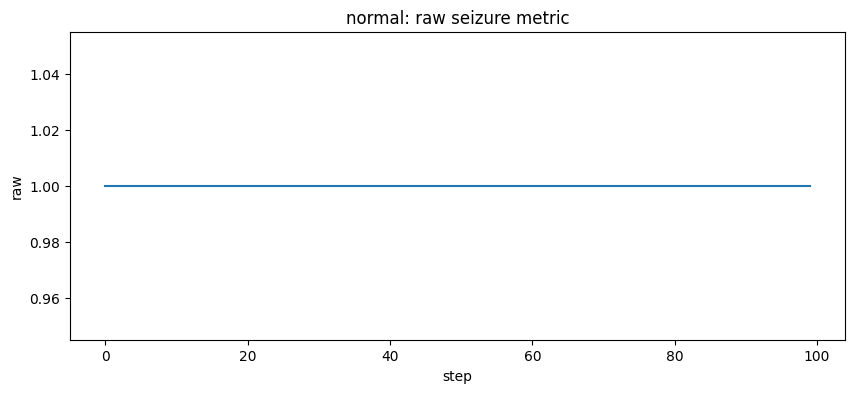

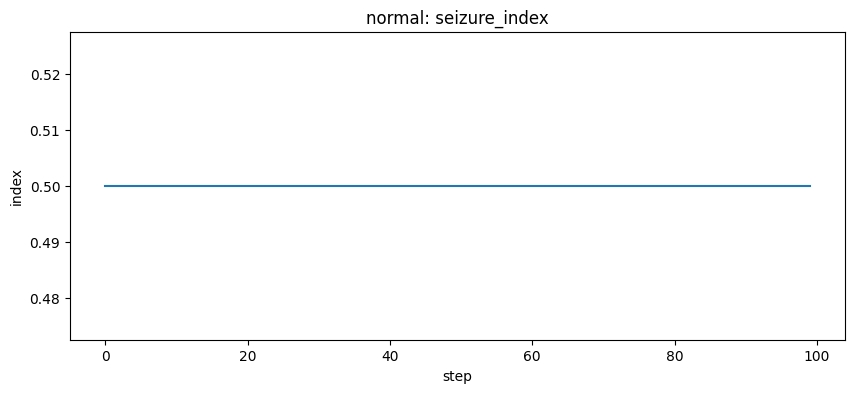

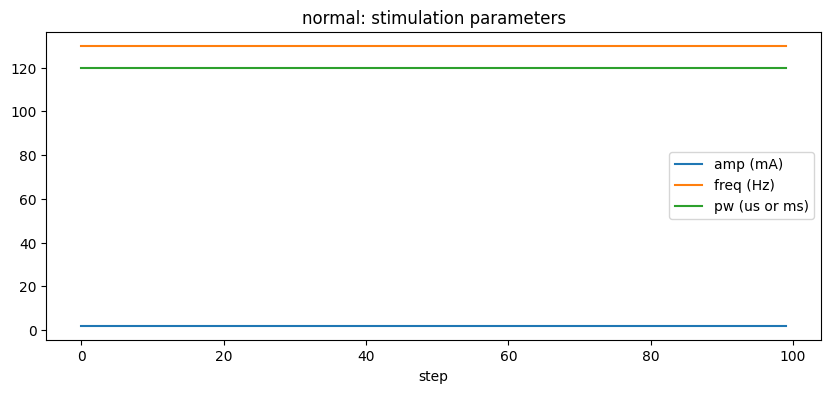

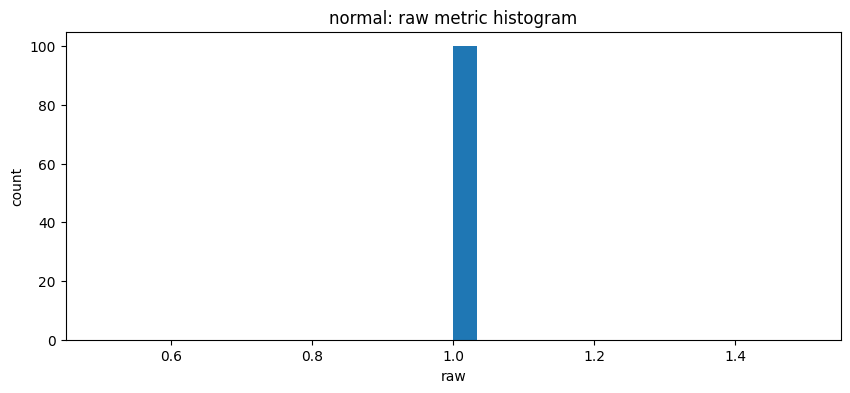

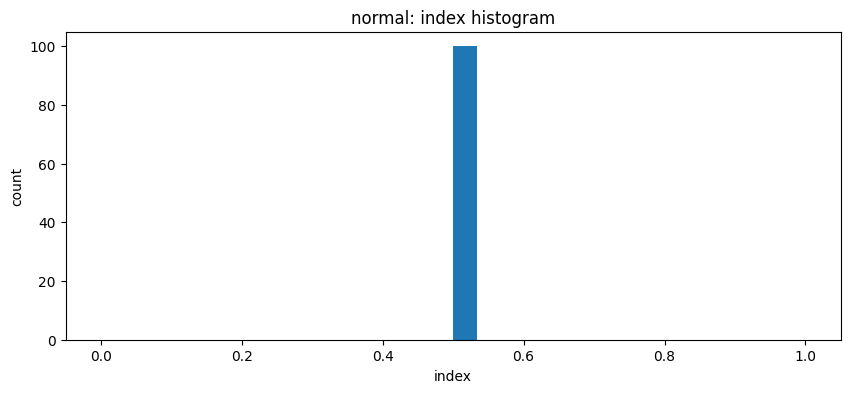

== normal summary ==
raw  min/mean/max: 1.0 1.0 1.0
idx  min/mean/max: 0.5 0.5 0.5
amp  min/mean/max: 2.0 2.0 2.0
freq min/mean/max: 130.0 130.0 130.0
pw   min/mean/max: 120.0 120.0 120.0


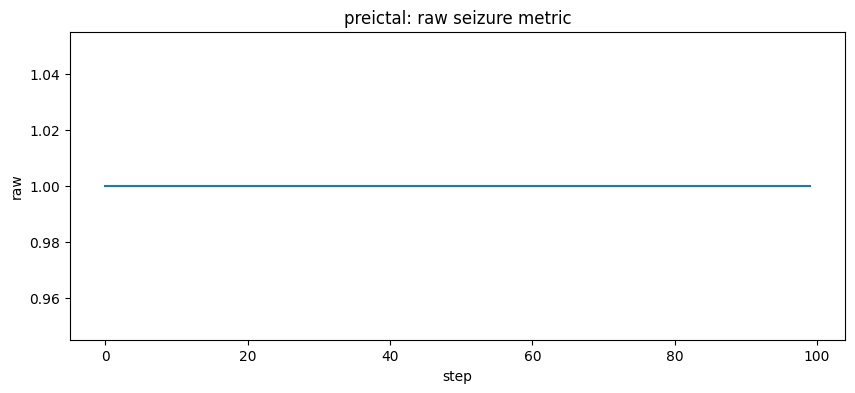

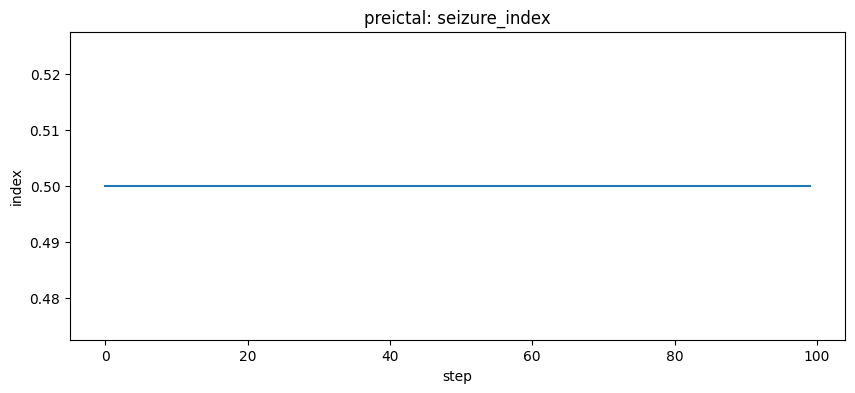

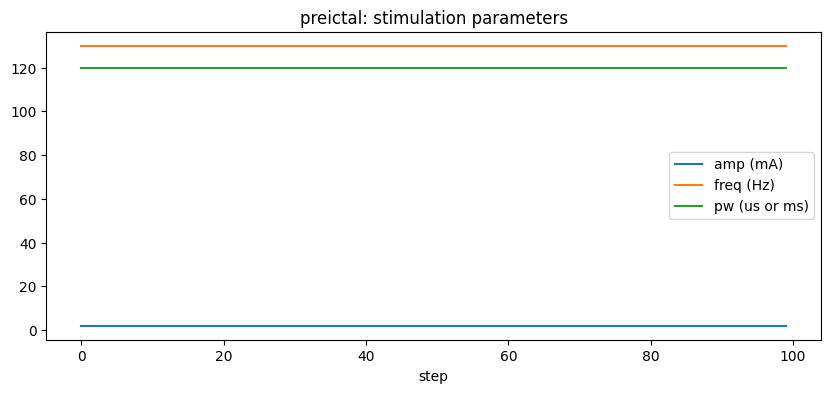

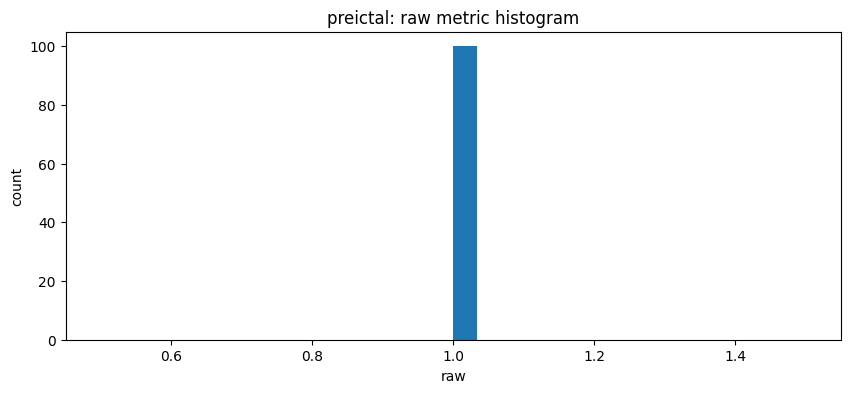

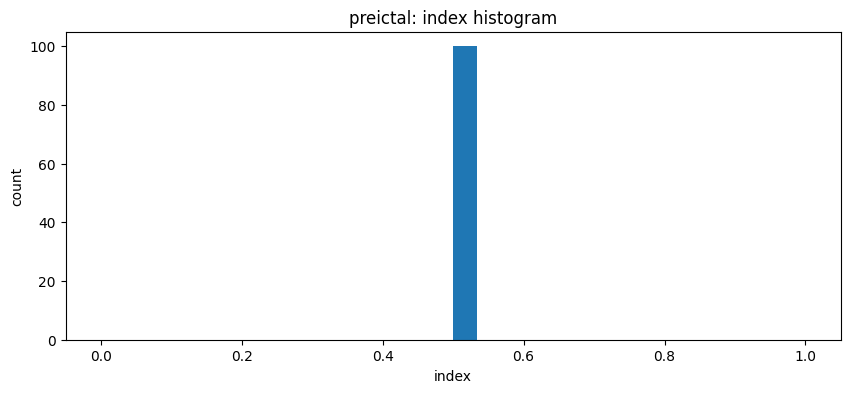

== preictal summary ==
raw  min/mean/max: 1.0 1.0 1.0
idx  min/mean/max: 0.5 0.5 0.5
amp  min/mean/max: 2.0 2.0 2.0
freq min/mean/max: 130.0 130.0 130.0
pw   min/mean/max: 120.0 120.0 120.0


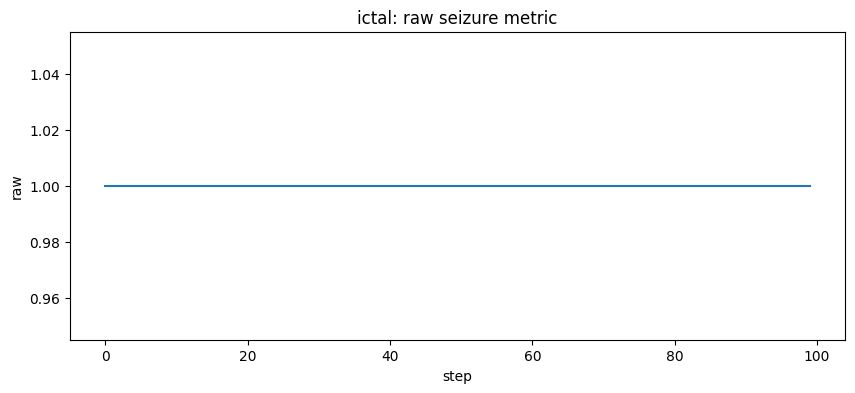

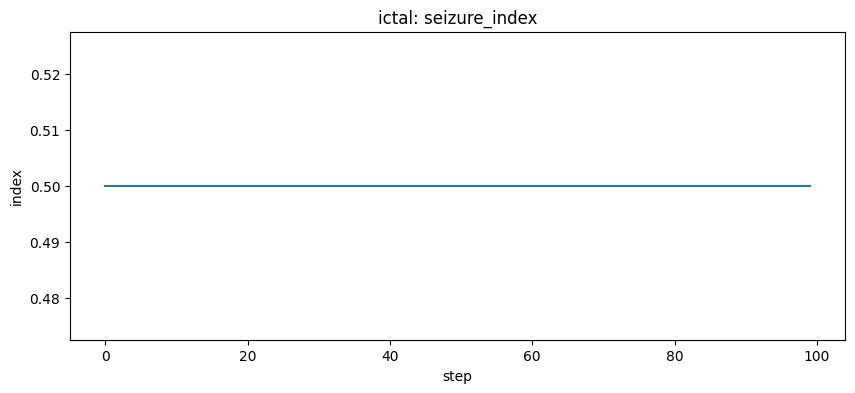

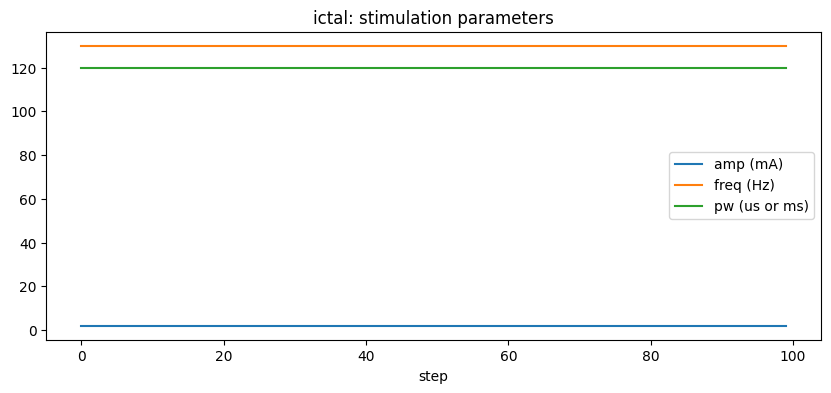

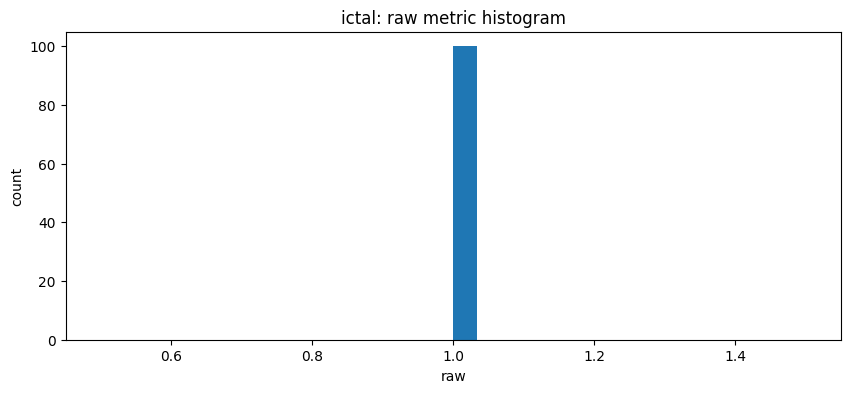

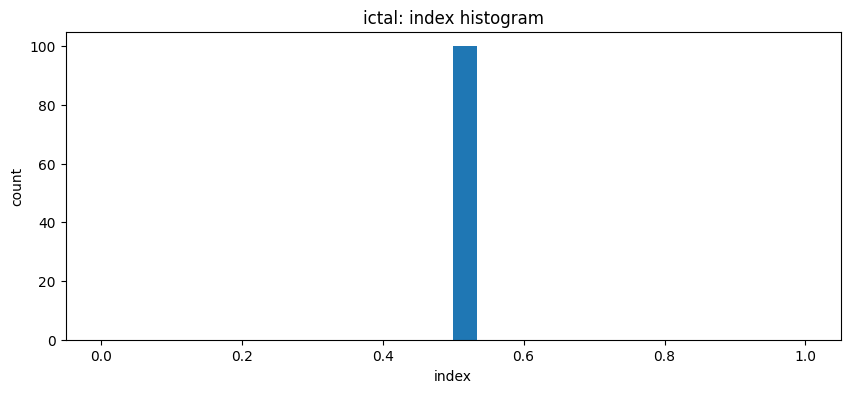

== ictal summary ==
raw  min/mean/max: 1.0 1.0 1.0
idx  min/mean/max: 0.5 0.5 0.5
amp  min/mean/max: 2.0 2.0 2.0
freq min/mean/max: 130.0 130.0 130.0
pw   min/mean/max: 120.0 120.0 120.0


In [193]:
import numpy as np
import matplotlib.pyplot as plt

def run_diagnostic_episode(env, regime="normal", n_steps=150, action=None, seed=0, capture_step=10):
    """
    Runs one episode worth of steps under a given regime and returns logged arrays.
    action: if None -> zero action; else callable(step)->action or constant np.array(3,)
    capture_step: which step to capture a window trace from (v_window/u_window)
    """
    obs, info = env.reset(seed=seed, options={"regime": regime})

    raws = []
    idxs = []
    rews = []
    amps = []
    freqs = []
    pws = []

    # capture window traces (if available)
    cap = {"t": None, "v": None, "u": None, "step": None}

    for t in range(n_steps):
        if action is None:
            a = np.zeros(3, dtype=np.float32)
        elif callable(action):
            a = np.asarray(action(t), dtype=np.float32)
        else:
            a = np.asarray(action, dtype=np.float32)

        obs, reward, terminated, truncated, info = env.step(a)

        raws.append(float(info.get("seizure_metric_raw", np.nan)))
        idxs.append(float(info.get("seizure_index", np.nan)))
        rews.append(float(reward))

        # pull stim params if you store them
        # (adapt keys if your env uses different names)
        stim = info.get("stim_params", None)
        if stim is None:
            # fallback: if you store current_params on env
            if hasattr(env, "current_params") and env.current_params is not None:
                amp, freq, pw = env.current_params
            else:
                amp, freq, pw = (np.nan, np.nan, np.nan)
        else:
            amp = stim.get("amp_mA", np.nan)
            freq = stim.get("freq_Hz", np.nan)
            pw = stim.get("pw_us", stim.get("pw_ms", np.nan))  # support either

        amps.append(float(amp))
        freqs.append(float(freq))
        pws.append(float(pw))

        # try to capture an example window trace
        if t == capture_step:
            # Your env already has t_window/v_window/u_window inside _simulate_window.
            # If you store them (recommended), pull them here.
            if "t_window" in info and "v_window" in info and "u_window" in info:
                cap["t"] = np.asarray(info["t_window"])
                cap["v"] = np.asarray(info["v_window"])
                cap["u"] = np.asarray(info["u_window"])
                cap["step"] = t
            else:
                # If not in info, attempt to fetch from env fields if you stored them
                for k_t, k_v, k_u in [("_last_t_window", "_last_v_window", "_last_u_window"),
                                      ("_t_window", "_v_window", "_u_window")]:
                    if hasattr(env, k_t) and hasattr(env, k_v) and hasattr(env, k_u):
                        cap["t"] = np.asarray(getattr(env, k_t))
                        cap["v"] = np.asarray(getattr(env, k_v))
                        cap["u"] = np.asarray(getattr(env, k_u))
                        cap["step"] = t
                        break

        if terminated or truncated:
            break

    return {
        "regime": regime,
        "raw": np.asarray(raws),
        "idx": np.asarray(idxs),
        "rew": np.asarray(rews),
        "amp": np.asarray(amps),
        "freq": np.asarray(freqs),
        "pw": np.asarray(pws),
        "cap": cap,
    }


def plot_diagnostics(result, show_hist=True, psd=True):
    regime = result["regime"]
    raw = result["raw"]
    idx = result["idx"]
    amp = result["amp"]
    freq = result["freq"]
    pw = result["pw"]
    cap = result["cap"]

    steps = np.arange(len(raw))

    # 1) raw seizure metric
    plt.figure(figsize=(10, 4))
    plt.plot(steps, raw)
    plt.title(f"{regime}: raw seizure metric")
    plt.xlabel("step")
    plt.ylabel("raw")
    plt.show()

    # 2) seizure index
    plt.figure(figsize=(10, 4))
    plt.plot(steps, idx)
    plt.title(f"{regime}: seizure_index")
    plt.xlabel("step")
    plt.ylabel("index")
    plt.show()

    # 3) DBS params
    plt.figure(figsize=(10, 4))
    plt.plot(steps, amp, label="amp (mA)")
    plt.plot(steps, freq, label="freq (Hz)")
    plt.plot(steps, pw, label="pw (us or ms)")
    plt.title(f"{regime}: stimulation parameters")
    plt.xlabel("step")
    plt.legend()
    plt.show()

    # 4) example window traces
    if cap["t"] is not None and cap["v"] is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(cap["t"], cap["v"], label="v(t)")
        if cap["u"] is not None:
            plt.plot(cap["t"], cap["u"], label="u(t)")
        plt.title(f"{regime}: example window trace (step {cap['step']})")
        plt.xlabel("time (s or internal units)")
        plt.legend()
        plt.show()

        # 5) PSD (optional)
        if psd:
            x = np.asarray(cap["v"], dtype=float)
            x = x - np.mean(x)
            if x.size >= 32:
                # estimate fs from time axis if possible
                t = np.asarray(cap["t"], dtype=float)
                if np.all(np.diff(t) > 0):
                    dt = float(np.median(np.diff(t)))
                    fs = 1.0 / dt
                else:
                    fs = 1000.0  # fallback

                from scipy.signal import welch
                f, Pxx = welch(x, fs=fs, nperseg=min(256, x.size))
                plt.figure(figsize=(10, 4))
                plt.semilogy(f, Pxx)
                plt.title(f"{regime}: PSD of v(t) (step {cap['step']})")
                plt.xlabel("Hz")
                plt.ylabel("PSD")
                plt.xlim(0, 80)
                plt.show()

    # 6) histograms
    if show_hist:
        plt.figure(figsize=(10, 4))
        plt.hist(raw[np.isfinite(raw)], bins=30)
        plt.title(f"{regime}: raw metric histogram")
        plt.xlabel("raw")
        plt.ylabel("count")
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.hist(idx[np.isfinite(idx)], bins=30)
        plt.title(f"{regime}: index histogram")
        plt.xlabel("index")
        plt.ylabel("count")
        plt.show()

    # Print summary stats
    print(f"== {regime} summary ==")
    print("raw  min/mean/max:", float(np.nanmin(raw)), float(np.nanmean(raw)), float(np.nanmax(raw)))
    print("idx  min/mean/max:", float(np.nanmin(idx)), float(np.nanmean(idx)), float(np.nanmax(idx)))
    print("amp  min/mean/max:", float(np.nanmin(amp)), float(np.nanmean(amp)), float(np.nanmax(amp)))
    print("freq min/mean/max:", float(np.nanmin(freq)), float(np.nanmean(freq)), float(np.nanmax(freq)))
    print("pw   min/mean/max:", float(np.nanmin(pw)), float(np.nanmean(pw)), float(np.nanmax(pw)))


# ---- Usage ----
# 1) Calibrate
cal = env.calibrate_seizure_scale(n_windows=300, regime="normal", seed=0)
print("Calibration:", cal)

# 2) Reset after calibration
env.reset(seed=0, options={"regime": "normal"})

# 3) Diagnostics per regime
for reg in ["normal", "preictal", "ictal"]:
    res = run_diagnostic_episode(env, regime=reg, n_steps=150, action=None, seed=0, capture_step=10)
    plot_diagnostics(res, show_hist=True, psd=True)


In [194]:
# Sanity check: seizure_index under no stim in different regimes
def mean_idx(regime, n=200):
    env.reset(options={"regime": regime})
    xs = []
    for _ in range(n):
        _, _, term, trunc, info = env.step(np.zeros(3, dtype=np.float32))
        xs.append(info["seizure_index"])
        if term or trunc:
            env.reset(options={"regime": regime})
    return float(np.mean(xs)), float(np.std(xs))

print("normal :", mean_idx("normal"))
print("preictal:", mean_idx("preictal"))
print("ictal  :", mean_idx("ictal"))


normal : (0.5, 0.0)
preictal: (0.5, 0.0)
ictal  : (0.5, 0.0)


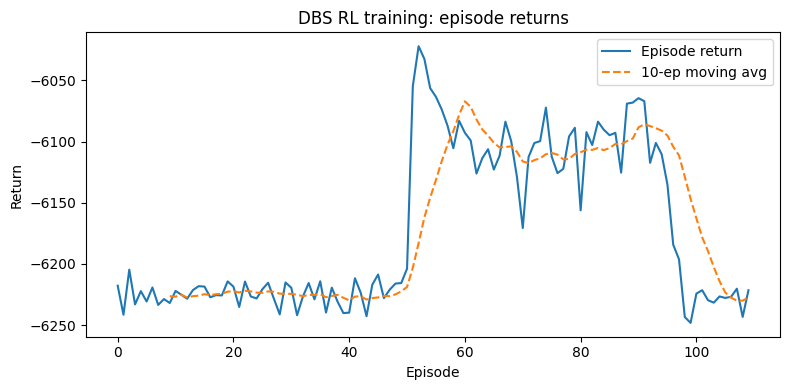

In [195]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.plot(episode_returns, label="Episode return")
# optional: moving average
window = 10
if len(episode_returns) >= window:
    ma = np.convolve(episode_returns,
                     np.ones(window)/window,
                     mode="valid")
    plt.plot(range(window-1, len(episode_returns)),
             ma, linestyle="--", label=f"{window}-ep moving avg")

plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("DBS RL training: episode returns")
plt.legend()
plt.tight_layout()
plt.show()


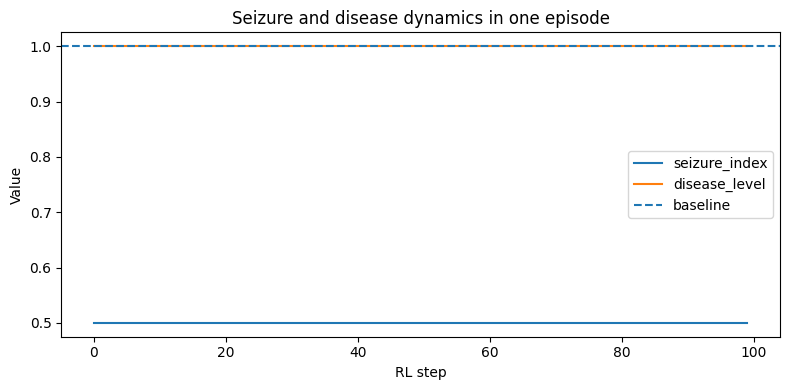

In [196]:
obs, info = env.reset(options={"regime": "ictal"})  # start ictal
seiz_traj = []
dis_traj = []

done = False
while not done:
    action = np.zeros(3, dtype=float)  # or your trained policy(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    seiz_traj.append(info["seizure_index"])
    dis_traj.append(info["disease_level"])
    done = terminated or truncated

plt.figure(figsize=(8, 4))
plt.plot(seiz_traj, label="seizure_index")
plt.plot(dis_traj, label="disease_level")
plt.axhline(env.seizure_baseline, linestyle="--", label="baseline")
plt.legend()
plt.xlabel("RL step")
plt.ylabel("Value")
plt.title("Seizure and disease dynamics in one episode")
plt.tight_layout()
plt.show()


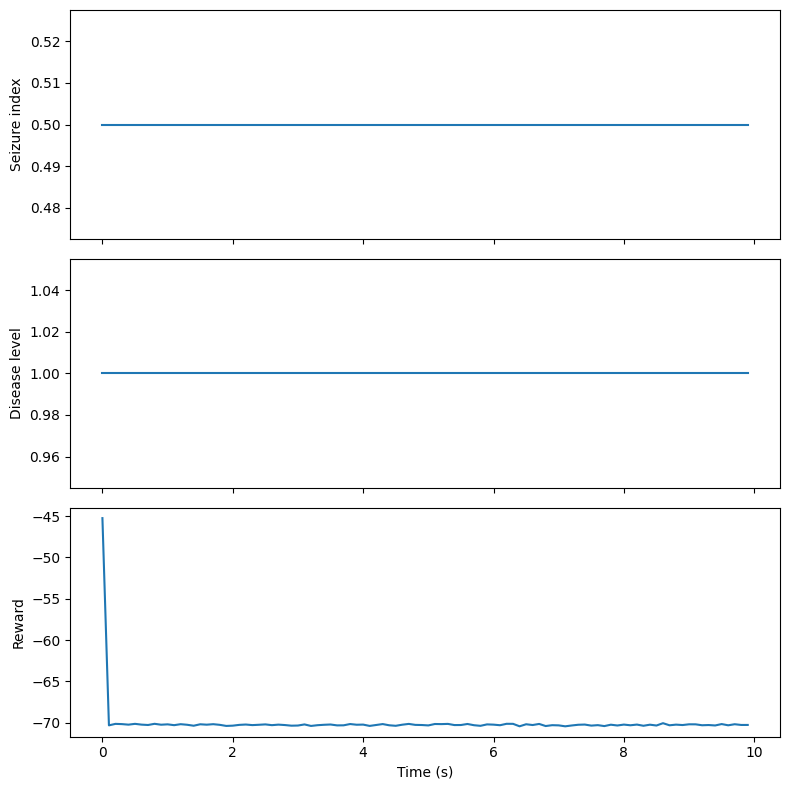

In [197]:
# Start from an epileptic regime
obs, info = env.reset(options={"regime": "ictal"})

seiz_list = []
disease_list = []
reward_list = []
time_list = []

for step in range(env.max_steps):
    # Use the SAC agent's learned policy
    action = agent.select_action(obs)

    obs, reward, terminated, truncated, info = env.step(action)

    seiz_list.append(info["seizure_index"])
    disease_list.append(info["disease_level"])
    reward_list.append(reward)
    time_list.append(step * env.step_T)

    if terminated or truncated:
        break

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(time_list, seiz_list)
axes[0].set_ylabel("Seizure index")

axes[1].plot(time_list, disease_list)
axes[1].set_ylabel("Disease level")

axes[2].plot(time_list, reward_list)
axes[2].set_ylabel("Reward")
axes[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


In [198]:
env = EpilepsyDBSCombinedEnv(
    default_regime="ictal",
    log_best_episodes=True,   # <--- crucial
    n_best_episodes=1
)

obs, info = env.reset(options={"regime": "ictal"})

done = False
while not done:
    # for now, just keep DBS parameters fixed:
    action = np.zeros(3, dtype=float)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

episodes = env.get_best_episodes()
episode = episodes[0]   # only one


AttributeError: 'EpilepsyDBSCombinedEnv' object has no attribute 'get_best_episodes'

In [199]:
import matplotlib.pyplot as plt
import numpy as np

t = episode["t"]       # shape (N_samples,)
v = episode["v"]       # JR output
u = episode["u"]       # DBS drive signal

fig, (ax_stim, ax_seiz) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={"height_ratios": [1, 2]}
)

# Top: stimulation signal (continuous DBS drive)
u_env = np.convolve(np.abs(u), np.ones(200)/200, mode="same")
ax_stim.plot(t, u_env)
ax_stim.set_ylabel("DBS |u(t)| envelope")
ax_stim.set_title("DBS stimulation")

# Bottom: 'seizure activity' – here using JR voltage
ax_seiz.plot(t, v)
ax_seiz.set_xlabel("Time (s)")
ax_seiz.set_ylabel("JR output v(t)")
ax_seiz.set_title("Network activity")

plt.tight_layout()
plt.show()


TypeError: 'int' object is not subscriptable

In [ ]:
seiz_idx = episode["seizure_index"]   # shape (num_steps,)
rewards  = episode["rewards"]         # shape (num_steps,)

# Disease level isn't in the episode log yet; we read it during the episode.
# For now, do a fresh run with explicit logging outside the env:
env2 = EpilepsyDBSCombinedEnv(default_regime="ictal")
obs, info = env2.reset(options={"regime": "ictal"})

seiz_traj = []
dis_traj  = []
rew_traj  = []
t_steps   = []

done = False
step_idx = 0
while not done:
    action = np.zeros(3, dtype=float)
    obs, reward, terminated, truncated, info = env2.step(action)

    seiz_traj.append(info["seizure_index"])
    dis_traj.append(info["disease_level"])
    rew_traj.append(info["reward"])
    t_steps.append(step_idx * env2.step_T)

    step_idx += 1
    done = terminated or truncated

seiz_traj = np.array(seiz_traj)
dis_traj  = np.array(dis_traj)
rew_traj  = np.array(rew_traj)
t_steps   = np.array(t_steps)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_steps, seiz_traj, label="seizure_index")
ax1.plot(t_steps, dis_traj, label="disease_level")
ax1.axhline(getattr(env2, "seizure_baseline", 0.7),
            linestyle="--", label="baseline")
ax1.set_ylabel("Value")
ax1.set_title("RL-level seizure & disease dynamics")
ax1.legend()

ax2.plot(t_steps, rew_traj)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Reward")
ax2.set_title("Reward per step")

plt.tight_layout()
plt.show()


In [ ]:
best = env.get_best_episodes()

# Save each best episode as a separate .npz file
import numpy as np

for i, ep in enumerate(best):
    np.savez_compressed(
        f"best_episode_{i}.npz",
        t=ep["t"],
        v=ep["v"],
        u=ep["u"],
        theta=ep["theta"],
        amp_fast=ep["amp_fast"],
        seizure_index=ep["seizure_index"],
        pac_index=ep["pac_index"],
        energy_norm=ep["energy_norm"],
        amp=ep["amp"],
        freq=ep["freq"],
        pw=ep["pw"],
        rewards=ep["rewards"],
        total_reward=ep["total_reward"],
    )


In [ ]:
def evaluate_fixed_dbs(
    env,
    regime="ictal",
    amp=5.0,
    freq=145.0,
    pw=90.0,
    n_steps=200,
):
    """
    Run an episode in `regime` with *fixed* DBS parameters and return
    time series and total reward.
    """
    obs, info = env.reset(options={"regime": regime})

    # Override current params and previous params to the desired fixed DBS
    amp, freq, pw = env._clip_params(amp, freq, pw)
    env.current_params = (amp, freq, pw)
    env.prev_params = env.current_params

    rewards = []
    seizure_ts = []
    disease_ts = []
    pac_ts = []
    energy_ts = []

    for _ in range(n_steps):
        # zero action = keep params unchanged
        action = np.zeros(3, dtype=float)
        obs, reward, terminated, truncated, info_step = env.step(action)

        rewards.append(reward)
        seizure_ts.append(info_step["seizure_index"])
        pac_ts.append(info_step["pac_index"])
        energy_ts.append(info_step["energy_norm"])
        disease_ts.append(env.disease_level)

        if terminated or truncated:
            break

    return {
        "rewards": np.array(rewards, dtype=float),
        "seizure": np.array(seizure_ts, dtype=float),
        "pac": np.array(pac_ts, dtype=float),
        "energy": np.array(energy_ts, dtype=float),
        "disease": np.array(disease_ts, dtype=float),
    }


In [ ]:
param_sets = {
    "SANTE_like_high":  {"amp": 5.0, "freq": 145.0, "pw": 90.0},
    "SANTE_like_low":   {"amp": 2.5, "freq": 145.0, "pw": 90.0},
    "init_130Hz":       {"amp": 2.0, "freq": 130.0, "pw": 120.0},
    "no_stim":          {"amp": 0.0, "freq": 130.0, "pw": 120.0},
}

results = {}
for name, p in param_sets.items():
    out = evaluate_fixed_dbs(
        env,
        regime="ictal",     # start in ictal state
        amp=p["amp"],
        freq=p["freq"],
        pw=p["pw"],
        n_steps=env.max_steps,
    )
    results[name] = out
    total_R = out["rewards"].sum()
    mean_R = out["rewards"].mean()
    print(f"{name}: total reward = {total_R:.3f}, mean reward/step = {mean_R:.3f}")


In [ ]:
import matplotlib.pyplot as plt

best = env.get_best_episodes()[-1]   # last run
t = best["t"]
v = best["v"]
u = best["u"]
seiz = best["seizure_index"]         # per-step values – you can upsample in time if you want
rewards = best["rewards"]

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

axes[0].plot(t, u)
axes[0].set_ylabel("DBS drive u(t)")
axes[0].set_title("DBS waveform")

axes[1].plot(t, v)
axes[1].set_ylabel("JR output v(t)")

# Optionally interpolate seizure_index to same time grid as t
axes[2].step(range(len(seiz)), seiz, where="post")
axes[2].set_ylabel("Seizure index")
axes[2].set_xlabel("Step or time")

plt.tight_layout()
plt.show()


In [ ]:
def mean_seiz(env, regime, n=200):
    try:
        env.reset(regime=regime)
    except TypeError:
        env.default_regime = regime
        env.reset()

    zs = []
    for _ in range(n):
        _, _, term, trunc, info = env.step(np.array([0.,0.,0.], dtype=np.float32))
        zs.append(info["seizure_index"])
        if term or trunc:
            try:
                env.reset(regime=regime)
            except TypeError:
                env.default_regime = regime
                env.reset()
    return float(np.mean(zs)), float(np.std(zs))

print("normal :", mean_seiz(env, "normal"))
print("preictal:", mean_seiz(env, "preictal"))
print("ictal  :", mean_seiz(env, "ictal"))


In [ ]:
import pandas as pd

rows = []
for name, out in results.items():
    rows.append({
        "policy": name,
        "mean_reward": out["rewards"].mean(),
        "total_reward": out["rewards"].sum(),
        "mean_seiz": out["seizure"].mean(),
        "final_disease": out["disease"][-1],
        "mean_energy": out["energy"].mean(),
    })

df = pd.DataFrame(rows)
print(df)


In [ ]:
import numpy as np
import pandas as pd

def _get_policy_action(policy, obs, deterministic=True):
    """
    Tries common policy interfaces.
    - If you have an SAC agent, rename `policy` accordingly or wrap it.
    """
    # 1) Stable-baselines3 style: policy.predict(obs, deterministic=True)
    if hasattr(policy, "predict"):
        a, _ = policy.predict(obs, deterministic=deterministic)
        return np.asarray(a, dtype=float).reshape(-1)

    # 2) Common custom: policy.act(obs, deterministic=True) or policy.select_action(obs, deterministic=True)
    for name in ["act", "select_action", "get_action"]:
        if hasattr(policy, name):
            fn = getattr(policy, name)
            try:
                a = fn(obs, deterministic=deterministic)
            except TypeError:
                a = fn(obs)
            return np.asarray(a, dtype=float).reshape(-1)

    raise AttributeError("Could not infer how to get actions from `policy`. Provide a wrapper with a .predict() or .act().")


def eval_policy(env, policy=None, regime="normal", n_episodes=5, max_steps=100, deterministic=True, kind="learned"):
    rows = []
    for ep in range(n_episodes):
        obs, info = env.reset(options={"regime": regime})
        ep_ret = 0.0
        seiz = []
        energy = []
        slew = []
        disease = []
        for t in range(max_steps):
            if kind == "no_action":
                action = np.zeros(3, dtype=float)
            elif kind == "random_action":
                action = np.random.uniform(-1.0, 1.0, size=(3,))
            else:
                action = _get_policy_action(policy, obs, deterministic=deterministic)

            obs, reward, terminated, truncated, info = env.step(action)
            ep_ret += float(reward)

            seiz.append(float(info.get("seizure_index", np.nan)))
            energy.append(float(info.get("energy_norm", np.nan)))
            slew.append(float(info.get("slew_penalty", np.nan)))
            disease.append(float(info.get("disease_level", np.nan)))

            if terminated or truncated:
                break

        rows.append({
            "regime": regime,
            "policy": kind if kind != "learned" else "learned",
            "episode_return": ep_ret,
            "mean_seizure": float(np.nanmean(seiz)),
            "mean_energy": float(np.nanmean(energy)),
            "mean_slew": float(np.nanmean(slew)),
            "final_disease": float(disease[-1]) if len(disease) else np.nan,
            "steps": len(seiz),
        })
    return pd.DataFrame(rows)


# ---- Run evaluation ----
# Set `policy` to your trained SAC policy/agent object.
# Example:
# policy = agent
policy = None  # <-- CHANGE THIS to your trained SAC agent/policy

regimes = ["normal", "preictal", "ictal"]
all_rows = []

for r in regimes:
    all_rows.append(eval_policy(env, policy=None, regime=r, n_episodes=5, max_steps=env.max_steps, kind="no_action"))
    all_rows.append(eval_policy(env, policy=None, regime=r, n_episodes=5, max_steps=env.max_steps, kind="random_action"))
    if policy is not None:
        all_rows.append(eval_policy(env, policy=policy, regime=r, n_episodes=5, max_steps=env.max_steps, kind="learned", deterministic=True))

df_eval = pd.concat(all_rows, ignore_index=True)
summary = df_eval.groupby(["regime", "policy"]).agg(
    mean_return=("episode_return", "mean"),
    std_return=("episode_return", "std"),
    mean_seizure=("mean_seizure", "mean"),
    mean_energy=("mean_energy", "mean"),
    mean_slew=("mean_slew", "mean"),
    final_disease=("final_disease", "mean"),
    mean_steps=("steps", "mean"),
).reset_index()

summary


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(episode_summaries)

# choose a regime to rank within (ictal is most meaningful)
df_ictal = df[df["regime"] == "ictal"].copy()

# best episodes by return
top = df_ictal.sort_values("return", ascending=False).head(10)

print(top[["episode","return","mean_seiz_idx","avg_amp","avg_freq","avg_pw"]])

# Scatter plots of param sets for top episodes
plt.figure()
plt.scatter(top["avg_amp"], top["avg_freq"])
plt.xlabel("Mean amplitude (mA)")
plt.ylabel("Mean frequency (Hz)")
plt.title("Top-10 ictal episodes: mean amp vs mean freq")
plt.show()

plt.figure()
plt.scatter(top["avg_amp"], top["avg_pw"])
plt.xlabel("Mean amplitude (mA)")
plt.ylabel("Mean pulse width (us)")
plt.title("Top-10 ictal episodes: mean amp vs mean pw")
plt.show()

plt.figure()
plt.scatter(top["avg_freq"], top["avg_pw"])
plt.xlabel("Mean frequency (Hz)")
plt.ylabel("Mean pulse width (us)")
plt.title("Top-10 ictal episodes: mean freq vs mean pw")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Episode return curve
plt.figure()
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episode returns")
plt.show()

# SAC internal curves (if available)
def safe_plot(arr, title, ylabel):
    if arr is None or len(arr) == 0:
        print(f"[Missing] {title} not logged")
        return
    plt.figure()
    plt.plot(arr)
    plt.xlabel("Update step")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

safe_plot(getattr(agent, "critic_losses", None), "Critic loss", "loss")
safe_plot(getattr(agent, "actor_losses", None), "Actor loss", "loss")
safe_plot(getattr(agent, "alpha_hist", None), "Alpha (temperature)", "alpha")
safe_plot(getattr(agent, "entropy_hist", None), "Policy entropy estimate", "entropy")


In [ ]:
BASELINES = {
    "SANTE_low":  {"amp": 1.0, "freq": 145.0, "pw": 90.0},
    "SANTE_high": {"amp": 3.0, "freq": 145.0, "pw": 90.0},
    "standard_130Hz": {"amp": 2.0, "freq": 130.0, "pw": 90.0},
    "low_freq": {"amp": 2.0, "freq": 50.0, "pw": 90.0},
}

import numpy as np
import pandas as pd

def rollout_fixed(env, params, regime="ictal", seed=0):
    obs, info = env.reset(seed=seed, options={"regime": regime})
    env.current_params = (params["amp"], params["freq"], params["pw"])
    env.prev_params = env.current_params

    rets = 0.0
    seiz = []
    energy = []
    slew = []

    for t in range(env.max_steps):
        # action is ignored if you directly set current_params; so instead
        # you should implement a helper env.step_params(...) or map params -> action
        # If your env uses actions only, do params->action mapping here.
        # For now, assume you have a function env.params_to_action(...)
        a = env.params_to_action(params["amp"], params["freq"], params["pw"])
        obs, r, term, trunc, info = env.step(a)
        rets += float(r)
        seiz.append(float(info["seizure_index"]))
        energy.append(float(info["cost_components"]["energy"]))
        slew.append(float(info["cost_components"]["slew"]))
        if term or trunc:
            break

    return {
        "return": rets,
        "mean_seizure_index": float(np.mean(seiz)),
        "max_seizure_index": float(np.max(seiz)),
        "mean_energy_cost": float(np.mean(energy)),
        "mean_slew_cost": float(np.mean(slew)),
        "steps": len(seiz),
    }


In [ ]:
rows = []
for name, p in BASELINES.items():
    out = rollout_fixed(env, p, regime="ictal", seed=0)
    out.update({"policy": name})
    rows.append(out)

df_base = pd.DataFrame(rows)
print(df_base.sort_values("return", ascending=False))


In [ ]:
env.seizure_metric = "line_length"  # use this if bandpower seems unstable at 100 ms
print(env.calibrate_seizure_scale(n_windows=300, regime="normal", seed=0))

def mean_index(regime, n=100):
    env.reset(regime=regime)
    idxs = []
    for _ in range(n):
        obs, r, done, info = env.step(np.array([0.0, 0.0, 0.0], dtype=np.float32))
        idxs.append(info["seizure_index"])
        if done:
            env.reset(regime=regime)
    return float(np.mean(idxs)), float(np.std(idxs))

print("normal mean/std:", mean_index("normal"))
print("ictal  mean/std:", mean_index("ictal"))
print("preictal mean/std:", mean_index("preictal"))


In [ ]:
import matplotlib.pyplot as plt

def _maybe_get(obj, names):
    for n in names:
        if hasattr(obj, n):
            return getattr(obj, n)
    return None

# Replace `agent` with your SAC agent variable if it exists in your notebook.
agent = sac_agent  # or whatever your instance variable is called

if agent is None:
    print("Set `agent = <your SAC agent>` for this cell.")
else:
    # Common history field names
    critic_hist = _maybe_get(agent, ["critic_losses", "q_losses", "critic_loss_hist", "loss_q_hist"])
    actor_hist  = _maybe_get(agent, ["actor_losses", "actor_loss_hist", "loss_pi_hist"])
    alpha_hist  = _maybe_get(agent, ["alpha_hist", "temperature_hist", "log_alpha_hist"])
    ent_hist    = _maybe_get(agent, ["entropy_hist", "policy_entropy_hist"])

    found_any = any(x is not None for x in [critic_hist, actor_hist, alpha_hist, ent_hist])

    if not found_any:
        print(
            "I could not find stored loss/alpha/entropy histories on `agent`.\n\n"
            "To log learning, you need to append scalars during each SAC update, e.g.:\n"
            "  self.critic_losses.append(float(q_loss))\n"
            "  self.actor_losses.append(float(pi_loss))\n"
            "  self.alpha_hist.append(float(alpha))   # if autotuning\n"
            "  self.entropy_hist.append(float(entropy))\n\n"
            "Where to add:\n"
            "- right after critic backward/step\n"
            "- right after actor backward/step\n"
            "- right after alpha update (if any)\n"
        )
    else:
        # Plot whatever exists
        plt.figure()
        if critic_hist is not None:
            plt.plot(np.asarray(critic_hist, dtype=float))
            plt.title("Critic loss history")
            plt.xlabel("Update")
            plt.ylabel("Loss")
            plt.show()

        plt.figure()
        if actor_hist is not None:
            plt.plot(np.asarray(actor_hist, dtype=float))
            plt.title("Actor loss history")
            plt.xlabel("Update")
            plt.ylabel("Loss")
            plt.show()

        if alpha_hist is not None:
            plt.figure()
            plt.plot(np.asarray(alpha_hist, dtype=float))
            plt.title("Alpha / temperature history")
            plt.xlabel("Update")
            plt.ylabel("Alpha")
            plt.show()

        if ent_hist is not None:
            plt.figure()
            plt.plot(np.asarray(ent_hist, dtype=float))
            plt.title("Policy entropy history")
            plt.xlabel("Update")
            plt.ylabel("Entropy")
            plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Set your trained policy/agent object here
policy = SACAgent  # <-- set to your trained SAC policy/agent

def collect_actions(env, policy, regime="normal", max_steps=100, deterministic=True):
    obs, info = env.reset(options={"regime": regime})
    acts = []
    infos = []
    for _ in range(max_steps):
        a = _get_policy_action(policy, obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(a)
        acts.append(a)
        infos.append(info)
        if terminated or truncated:
            break
    return np.asarray(acts, dtype=float), infos

def summarize_actions(actions):
    # proportions relative to your quantisation thresholds
    thr = 1.0/3.0
    cols = []
    for i in range(actions.shape[1]):
        x = actions[:, i]
        cols.append({
            "dim": i,
            "mean": float(np.mean(x)),
            "std": float(np.std(x)),
            "p_neg": float(np.mean(x < -thr)),
            "p_zero": float(np.mean((x >= -thr) & (x <= thr))),
            "p_pos": float(np.mean(x > thr)),
        })
    return pd.DataFrame(cols)

if policy is None:
    print("Set `policy = <your trained SAC policy/agent>` first.")
else:
    for r in ["normal", "preictal", "ictal"]:
        acts, infos = collect_actions(env, policy, regime=r, max_steps=env.max_steps, deterministic=True)
        print(f"\nRegime: {r}, steps: {len(acts)}")
        display(summarize_actions(acts))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_fixed_policy(env, action_vec, regime="ictal", n_steps=100, label="policy"):
    obs, info = env.reset(options={"regime": regime})
    seiz, energy, amp, freq, pw = [], [], [], [], []
    for _ in range(n_steps):
        obs, reward, terminated, truncated, info = env.step(np.array(action_vec, dtype=float))
        seiz.append(float(info["seizure_index"]))
        energy.append(float(info["energy_norm"]))
        amp.append(float(info["amp"]))
        freq.append(float(info["freq"]))
        pw.append(float(info["pw"]))
        if terminated or truncated:
            break
    return {
        "label": label,
        "seizure": np.asarray(seiz),
        "energy": np.asarray(energy),
        "amp": np.asarray(amp),
        "freq": np.asarray(freq),
        "pw": np.asarray(pw),
    }

regime = "ictal"
N = env.max_steps

runs = [
    run_fixed_policy(env, [0, 0, 0], regime=regime, n_steps=N, label="no_change"),
    run_fixed_policy(env, [+1, +1, +1], regime=regime, n_steps=N, label="always_increase"),
    run_fixed_policy(env, [-1, -1, -1], regime=regime, n_steps=N, label="always_decrease"),
]

plt.figure()
for r in runs:
    plt.plot(r["seizure"], label=r["label"])
plt.title(f"Seizure index under fixed policies ({regime})")
plt.xlabel("Step")
plt.ylabel("Seizure index")
plt.legend()
plt.show()

plt.figure()
for r in runs:
    plt.plot(r["energy"], label=r["label"])
plt.title(f"Energy norm under fixed policies ({regime})")
plt.xlabel("Step")
plt.ylabel("Energy norm")
plt.legend()
plt.show()

plt.figure()
for r in runs:
    plt.plot(r["amp"], label=r["label"])
plt.title(f"Amp (mA) under fixed policies ({regime})")
plt.xlabel("Step")
plt.ylabel("mA")
plt.legend()
plt.show()

plt.figure()
for r in runs:
    plt.plot(r["freq"], label=r["label"])
plt.title(f"Freq (Hz) under fixed policies ({regime})")
plt.xlabel("Step")
plt.ylabel("Hz")
plt.legend()
plt.show()

plt.figure()
for r in runs:
    plt.plot(r["pw"], label=r["label"])
plt.title(f"PW (us) under fixed policies ({regime})")
plt.xlabel("Step")
plt.ylabel("us")
plt.legend()
plt.show()


## Smoke Test - Run This First!


In [ ]:
print("=== Smoke Test ===")
test_env = EpilepsyDBSCombinedEnv()
test_env.seizure_metric = "bandpower_ratio"
test_env.seizure_band = (8.0, 30.0)

cal = test_env.calibrate_seizure_scale(n_windows=50, regime="normal", seed=0)
print("✓ Calibration OK")

obs, info = test_env.reset(options={"regime": "ictal"})
print("✓ Reset OK")
print("  obs:", obs)
print("  info keys:", list(info.keys()))

for i in range(10):
    action = np.zeros(3)
    obs, reward, term, trunc, info = test_env.step(action)
    print(f"  Step {i}: reward={reward:.2f}, seiz={info['seizure_index']:.4f}")
    assert np.all(np.isfinite(obs)), "Non-finite obs!"
    assert np.isfinite(reward), "Non-finite reward!"
    if term or trunc:
        break

print("\n✓✓✓ SMOKE TEST PASSED ✓✓✓")